# Setup

#### Set the working directory to ../systematic-clusters-analysis_shahein-et.al

In [4]:
%cd "../"

/Users/transcend/SynologyDrive/python_analysis/systematic-clusters-analysis_shahein-et.al


#### Import

In [1]:
import xlrd
import json
import os
import pickle
import emcee
import corner

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import lmfit as lm
from lmfit import Model, fit_report

from more_itertools import powerset
from sympy.solvers import solve
from sympy import Symbol

from matplotlib.ticker import FixedLocator, FormatStrFormatter, LogFormatter

matplotlib.rcParams['font.sans-serif'] = "Arial" # Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.family'] = "sans-serif" # Then, "ALWAYS use sans-serif fonts"
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16

%load_ext blackcellmagic

In [94]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

xlrd==2.0.1
json==2.0.9
emcee==3.1.0
corner==2.2.1
numpy==1.20.2
pandas==1.2.5
matplotlib==3.3.4
seaborn==0.11.1
lmfit==1.0.2


#### Saving and loading functions

In [2]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

## Load and process data, run helper functions and create dictionaries

In [25]:
src = 'mitomi_zif268.xlsx'
filepath = os.path.join('input_datasets','in-vitro',src)
datafile = pd.ExcelFile(filepath)

dfs = []
for sn in [sn for sn in datafile.sheet_names if sn not in ['README']]: 
    df = pd.read_excel(datafile, sheet_name=sn)
    df['Date'] = sn
#     df['date'] = df['date'].astype(np.int32)
    dfs.append(df)
           
fdf = pd.concat(dfs)
fdf['TgtName'] = fdf['TgtName'].apply(lambda x: x.replace("'", '').strip().upper()) #remove apostrophes
fdf = fdf.reset_index(drop=True)

print(fdf)

      Flags  Column  Row   15a    25a   35a     45a    55b    65a   65b  \
0         0       1    1  2927   6481  3665  3708.0  10937  25204  3710   
1         0       2    1  2925   6292  3639  3669.0  11011  24244  3706   
2         0       3    1  2928   6469  3671  3696.0  11762  16144  3759   
3         0       4    1  2928   6839  3668  3688.0  12597   7313  3748   
4         0       5    1  2940  12895  3776  3792.0  11892  15209  3802   
...     ...     ...  ...   ...    ...   ...     ...    ...    ...   ...   
5371    100      44   16  2870  11473  4768     NaN   4139   5173  4068   
5372    100      45   16  2864   8204  5038     NaN   4865   5335  4766   
5373      0      46   16  2860   8527  3968     NaN   3858   4342  3757   
5374      0      47   16  2855   7943  4011     NaN   3820   4427  3720   
5375      0      48   16  2851  12262  4058     NaN   3899   4652  3806   

                                                TgtName      Date  
0        (17)A11(-3)A11(-3)A11(

### Calculate complex and free protein columns

In [26]:
occ_cal = 0.6758 # occupancy calibration factor (SBC model), see Supplemental Figure S4 E) 

fdf['Free'] = fdf['55b'] - fdf['65b']
fdf['Free_nM'] = fdf['Free'] / 9.68 # See Supplemental Figure S2 D) for calibration curve
fdf['DNA'] = fdf['25a'] - fdf['15a']
fdf['Complex_raw'] = fdf['65a'] - fdf['35a']
fdf['Complex'] = fdf['Complex_raw'] / fdf['DNA']
fdf['Meanocc'] = fdf['Complex']/occ_cal

fdf['TgtName'].replace('', np.nan, inplace=True)
fdf.dropna(subset=['TgtName'], inplace=True)
fdf = fdf.loc[fdf['Flags'] == 0]

      Flags  Column  Row   15a    25a   35a     45a    55b    65a   65b  \
0         0       1    1  2927   6481  3665  3708.0  10937  25204  3710   
1         0       2    1  2925   6292  3639  3669.0  11011  24244  3706   
2         0       3    1  2928   6469  3671  3696.0  11762  16144  3759   
3         0       4    1  2928   6839  3668  3688.0  12597   7313  3748   
4         0       5    1  2940  12895  3776  3792.0  11892  15209  3802   
...     ...     ...  ...   ...    ...   ...     ...    ...    ...   ...   
5371    100      44   16  2870  11473  4768     NaN   4139   5173  4068   
5372    100      45   16  2864   8204  5038     NaN   4865   5335  4766   
5373      0      46   16  2860   8527  3968     NaN   3858   4342  3757   
5374      0      47   16  2855   7943  4011     NaN   3820   4427  3720   
5375      0      48   16  2851  12262  4058     NaN   3899   4652  3806   

                                                TgtName      Date  Free  \
0        (17)A11(-3)A11(

### Helper functions and dictionaries

#### Create information dictionaries for the targets as references

In [7]:
target_info = pd.read_csv(os.path.join('input_datasets','in-vitro','target_info.csv'), index_col=0)

def parse_sites(siteString):
    try:
        sites = siteString.strip().replace(' ', '').split(',')
    except:
        sites = []
    return sites

def parse_libraries(librariesString):
    try:
        libraries = librariesString.strip().replace(' ', '').split(',')
    except:
        libraries = []
    return libraries

# Parse the site info for each target
site_info = {}
for tgt in target_info.index.values:
    site_info[tgt] = parse_sites(target_info.loc[tgt, 'Sites']) #create a dictionary {key: tgt name, value: which sites (with repeats) are in the target}
    
# Parse the library info for each target
library_info = {}
for tgt in target_info.index.values:
    library_info[tgt] = parse_libraries(target_info.loc[tgt, 'Libraries'])
# Make a lookup to go from site labels to single-site targets
single_sites = np.unique(sum(site_info.values(), []))

referenceSingleTargets = {} 
for ss in single_sites:
    if ss == 'None':
        continue
    referenceSingleTargets[ss] = ss+'XXXXX' #{key: single site name, value: target name containing that single site alone}

#### mins_to_index

In [8]:
def mins_to_index(minsInterval, listOfMins):
    """
    Turn a minutes time interval into index time interval.
    
    Take as input the minutes time interval, and a list of minutes for the channel in question.
    pc['timeInterval'], loD[0][channelTimevals]
    """
    listOfMins = np.array(listOfMins)
    
    indices = np.where(np.logical_and(listOfMins>=minsInterval['start'], listOfMins<=minsInterval['stop']))
    indices = indices[0]
    
    start = indices[0]
    end = indices[-1]
    
    return start,end

# Relating mean occupancy predictions to expression

For all targets, generate predicted occupancies using an independent stat. mech. model parameterized by the single binding site targets' fits

### Fit data to ISMM

In [15]:
def independent_multisite_fitting(x, numSites, de1=-18):
    
    C0 = 0.6e9 #reference concentration parameter  

    numSitesStates = np.array([len(z) for z in list(powerset(np.arange(0,numSites)))]) #creates a list where each element corresponds to a different state of the system, and each value is the number of sites bound in that state
    
    relmults = np.power.outer((x/C0),numSitesStates) * np.exp(numSitesStates*(-de1)) #matrix of relative multiplicities, note that unbound (z0 = 1) is handled implicitly

    ztot = np.sum(relmults, axis=1) #for each datapoint calculate the partition function (sum over relmults of all states)
    
    occ = (relmults@numSitesStates)/ztot #for each datapoint, calculate the occupancy (vector multiply numSitesStates), divide by ztot elementwise

    return(occ)

#### Fit the data to the independent 1-parameter stat.mech. model, which assumes all sites in a target are the same affinity

In [22]:
C0 = 0.6e9 #reference concentration parameter

directory = 'in-vitro_fits_plots'
subdirectory = 'Zif268'

target_info = pd.read_csv(os.path.join('input_datasets','in-vitro','target_info.csv'), index_col=0)

imsfmodel = Model(independent_multisite_fitting)

xs = np.logspace(-1, 5, 200)

params_df = pd.DataFrame()
ptiles_df = pd.DataFrame()

ptiles = range(0,101)

for tgt, tgtgrp in fdf.groupby('TgtName'):
        
        if tgt not in ['XXXXXX','W2XXXXX','A11XXXXX','M1XXXXX','W3XXXXX','W1XXXXX','W4XXXXX','M2XXXXX',
                       'M3XXXXX','M4XXXXX','M5XXXXX','M6XXXXX','A4XXXXX','A5XXXXX','M1M2XXXX','M1M2M3XXX',
                       'M1M2M3M4XX','M1M2M3M4M5X','M1M2M3M4M5M6','W2W3W1W4W3W2']: 
            continue
        
        print(tgt)
        
        nrSites = target_info.loc[tgt,'NumSites']
        if tgt == 'XXXXXX':
            nrSites=1 # use single-site model to model non-specific target
        
        params = []

        tgtgrp = tgtgrp.loc[(tgtgrp['Free_nM']>0)&(tgtgrp['Meanocc']>0)]
        xd, yd = (tgtgrp['Free_nM'], tgtgrp['Meanocc']) #set x and y values

        yd = yd.values.flatten() #make into 1-dimensional np.array
        xd = xd.values.flatten()
        
        #initialize parameter values
        params = imsfmodel.make_params(de1=-18, numSites=float(nrSites))
        params['de1'].min = -6
        params['de1'].max = -22        
        params['numSites'].vary=False
        
        #use traditional minimizer to get an initial estimate, and then use MCMC to explore parameter space around those values
        result = imsfmodel.fit(yd, params, x=xd)
        
        #set up and run MCMC
        emcee_kws = dict(steps=10000, burn=300, thin=10, is_weighted=False, progress=True) 
        emcee_params = result.params.copy()
        result_emcee = imsfmodel.fit(yd, emcee_params, x=xd, method='emcee', fit_kws=emcee_kws)
        result_emcee.col_deriv = None # lmfit has a bug and fails to set this parameter. The model can't be saved without it being set!

        rps = result_emcee.params
        np.savetxt(os.path.join(directory,subdirectory,'1par_statmech_measured','{}_flatchain_imsf_model.csv'.format(tgt)), result_emcee.flatchain, delimiter=',') #save chain
        lm.model.save_modelresult(rps, (os.path.join(directory,subdirectory,'1par_statmech_measured','{}_fitresult_imsf_model.model'.format(tgt)))) #save model results
        
        #create a dataframe of parameter values 
        d = result_emcee.params.valuesdict()
        d['tgt'] = tgt
        params_df = pd.concat([params_df, pd.DataFrame(d, index=[0])])
        
        #create a dataframe of percentiles of parameter values
        pp = result_emcee.flatchain.apply(np.percentile, args=[ptiles])
        pp['tgt'] = tgt
        pp['ptile'] = ptiles     
        ptiles_df = pd.concat([ptiles_df, pp])
        
        #Barebones plot of the fitted function and residuals; plot with confidence intervals in a subsequent cell
        fig = plt.figure(figsize=(4,6))
        gs = fig.add_gridspec(2, 1)
        ax1 = fig.add_subplot(gs[0,0])
        ax2 = fig.add_subplot(gs[1,0])
        ax1.plot(xs, result.eval(params=result_emcee.params, x=xs)) # plot the model for that target
        ax1.plot(xd, yd, 'k.') # plot the datapoints for that target
        result_emcee.plot_residuals(ax=ax2) # plot difference between predicted and actual (residuals)

        for ax in (ax1, ax2):
            ax.set_xlim([1, 3e3])
            ax.set_xscale('log')
        ax2.set_xlabel('Free TF (nM)')
        ax1.set_ylabel('Mean Occupancy (RU)')
        ax2.set_ylabel('Residual')

        ax1.set_title("{} Kd={:.2f}".format(tgt, (C0)*np.exp(rps['de1'].value))) # Convert from delE (in Kb*T units) to Kd 
        ax2.set_title(None)
        plt.tight_layout()
        plt.savefig(os.path.join(directory,subdirectory,'1par_statmech_measured','{}_fit_imsf_model.png'.format(tgt)), dpi=300)

        plt.clf()
#         emcee_corner = corner.corner(result_emcee.flatchain, labels=result_emcee.var_names, truths=list(result_emcee.params.valuesdict().values()))
#         plt.savefig(os.path.join(directory,subdirectory,'measured','{}_corner_imsf_model.png'.format(tgt)), dpi=300)
#         plt.close('all')

params_df.reset_index(drop=True, inplace=True)
params_df.set_index('tgt', drop=True, inplace=True)
params_df.to_csv(os.path.join(directory,subdirectory,'1par_statmech_measured','fit_params_imsf_model.csv'))
ptiles_df = ptiles_df.set_index(['tgt', 'ptile'])
ptiles_df.to_csv(os.path.join(directory,subdirectory,'1par_statmech_measured','fit_params_percentiles_imsf-model.csv'))

  2%|▏         | 10/500 [00:00<00:05, 92.79it/s]

A11XXXXX


100%|██████████| 500/500 [00:05<00:00, 90.66it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [22.51181631 59.54601093]


  2%|▏         | 10/500 [00:00<00:05, 93.92it/s]

A4XXXXX


100%|██████████| 500/500 [00:05<00:00, 96.05it/s] 


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [18.13177401 58.387893  ]


  2%|▏         | 9/500 [00:00<00:05, 86.04it/s]

A5XXXXX


100%|██████████| 500/500 [00:05<00:00, 90.77it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [18.17155683 57.81111978]


  1%|          | 4/500 [00:00<00:12, 39.67it/s]

M1M2M3M4M5M6


100%|██████████| 500/500 [00:11<00:00, 43.35it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [20.03384846 55.34564345]


  1%|▏         | 7/500 [00:00<00:07, 61.65it/s]

M1M2M3M4M5X


100%|██████████| 500/500 [00:07<00:00, 63.21it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [20.60062275 53.5421395 ]


  2%|▏         | 8/500 [00:00<00:06, 73.47it/s]

M1M2M3M4XX


100%|██████████| 500/500 [00:06<00:00, 77.08it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [22.64646484 56.31919679]


  2%|▏         | 8/500 [00:00<00:06, 75.55it/s]

M1M2M3XXX


100%|██████████| 500/500 [00:06<00:00, 78.89it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [21.48042121 54.33410852]


  2%|▏         | 8/500 [00:00<00:06, 79.00it/s]

M1M2XXXX


100%|██████████| 500/500 [00:05<00:00, 85.84it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [21.01870111 58.22256053]


  2%|▏         | 9/500 [00:00<00:06, 81.36it/s]

M1XXXXX


100%|██████████| 500/500 [00:05<00:00, 90.96it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [19.61502672 57.3404395 ]


  2%|▏         | 9/500 [00:00<00:05, 86.15it/s]

M2XXXXX


100%|██████████| 500/500 [00:05<00:00, 94.46it/s] 


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [19.92735879 59.4523608 ]


  2%|▏         | 9/500 [00:00<00:05, 89.41it/s]

M3XXXXX


100%|██████████| 500/500 [00:05<00:00, 92.13it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [17.54568062 58.56509831]


  2%|▏         | 9/500 [00:00<00:06, 80.67it/s]

M4XXXXX


100%|██████████| 500/500 [00:05<00:00, 94.68it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [17.3877211  58.27090256]


  2%|▏         | 9/500 [00:00<00:05, 85.06it/s]

M5XXXXX


100%|██████████| 500/500 [00:05<00:00, 98.15it/s] 


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [19.23278585 56.65642275]


  2%|▏         | 8/500 [00:00<00:06, 79.68it/s]

M6XXXXX


100%|██████████| 500/500 [00:05<00:00, 95.69it/s] 


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [18.19182851 58.86737953]


  2%|▏         | 8/500 [00:00<00:06, 77.94it/s]

W1XXXXX


100%|██████████| 500/500 [00:05<00:00, 95.23it/s] 


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [26.8075078  58.88999817]


  1%|▏         | 7/500 [00:00<00:07, 69.37it/s]

W2W3W1W4W3W2


100%|██████████| 500/500 [00:06<00:00, 72.82it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [18.68156167 54.65186792]


  2%|▏         | 9/500 [00:00<00:05, 89.90it/s]

W2XXXXX


100%|██████████| 500/500 [00:05<00:00, 93.28it/s] 


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [27.14333819 61.14849706]


  1%|▏         | 7/500 [00:00<00:07, 69.01it/s]

W3XXXXX


100%|██████████| 500/500 [00:05<00:00, 95.71it/s] 


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [22.54234861 59.71339763]


  2%|▏         | 9/500 [00:00<00:05, 89.83it/s]

W4XXXXX


100%|██████████| 500/500 [00:05<00:00, 93.91it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [21.13060724 59.68911024]


  2%|▏         | 9/500 [00:00<00:05, 89.27it/s]

XXXXXX


100%|██████████| 500/500 [00:05<00:00, 89.33it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [25.25014867 55.29281106]


<Figure size 288x432 with 0 Axes>

<Figure size 288x432 with 0 Axes>

<Figure size 288x432 with 0 Axes>

<Figure size 288x432 with 0 Axes>

<Figure size 288x432 with 0 Axes>

<Figure size 288x432 with 0 Axes>

<Figure size 288x432 with 0 Axes>

<Figure size 288x432 with 0 Axes>

<Figure size 288x432 with 0 Axes>

<Figure size 288x432 with 0 Axes>

<Figure size 288x432 with 0 Axes>

<Figure size 288x432 with 0 Axes>

<Figure size 288x432 with 0 Axes>

<Figure size 288x432 with 0 Axes>

<Figure size 288x432 with 0 Axes>

<Figure size 288x432 with 0 Axes>

<Figure size 288x432 with 0 Axes>

<Figure size 288x432 with 0 Axes>

<Figure size 288x432 with 0 Axes>

<Figure size 288x432 with 0 Axes>

#### Update fit plots to include a sampling of the posterior distribution

In [23]:
# Sample the flatchain and produce and return simulated results
def eval_samples(flatchain, model, x, N, nrSites):
    
    fc = flatchain
    
    results = np.zeros([len(x), N])
    params_all = []
    inds = np.random.randint(low=int(0.1*len(fc)), high=len(fc), size=N) #randomly choose 300 parameter-sets from the flatchain
    for i,ind in enumerate(inds):
        sample = fc[ind]
        params_all.append(sample)
        params = lm.Parameters() #Parameters class/object that can receive parameters as input
        if len(sample) == 2:
            params.add_many(('de1', sample[0]), ('_lnsigma', sample[1]), ('numSites', nrSites)) #store the sample parameters
        elif len(sample) == 1: #defensive programming
            params.add_many(('de1', sample[0]), ('numSites', nrSites))
        results[:, i] = model.eval(x=x, params=params) #for each x-value generate an occupancy value by feeding the parameters back into the model (supplied in argument).
    return {'sims': results, 'params': np.array(params_all)}

#### First generate the sims (sample the posterior distribution) for the targets characterized in vitro

In [25]:
C0 = 0.6e9
xs = np.logspace(-1,5,10000) #note: logspace so -1 = 10^-1 = 1/10
N=300

target_info = pd.read_csv(os.path.join('input_datasets','in-vitro','target_info.csv'), index_col=0)

dir1 = 'in-vitro_fits_plots'
dir2 = 'Zif268'

params_df = pd.read_csv(os.path.join(dir1,dir2,'1par_statmech_measured','fit_params_imsf_model.csv'), index_col=0)
ptiles_df = pd.read_csv(os.path.join(dir1,dir2,'1par_statmech_measured','fit_params_percentiles_imsf-model.csv'), index_col=[0,1])

indexlist = params_df.index.tolist()

smmodel = Model(independent_multisite_fitting)

for tgt, tgtgrp in fdf.groupby('TgtName'):
    
    if tgt not in ['XXXXXX','W2XXXXX','A11XXXXX','M1XXXXX','W3XXXXX','W1XXXXX','W4XXXXX',
                   'M2XXXXX','M3XXXXX','M4XXXXX','M5XXXXX','M6XXXXX','A4XXXXX','A5XXXXX',
                   'M1M2XXXX','M1M2M3XXX','M1M2M3M4XX','M1M2M3M4M5X','M1M2M3M4M5M6','W2W3W1W4W3W2']: 
        continue

    print(tgt)

    params = []

    nrSites = target_info.loc[tgt,'NumSites']

    fc = np.loadtxt(os.path.join(dir1,dir2,'1par_statmech_measured','{}_flatchain_imsf_model.csv'.format(tgt)), delimiter=',')

    results = eval_samples(fc, smmodel, xs, N, nrSites)
    simsIMSF = results['sims'] # these are the predicted occupancy values associated with the sample parameter sets
    params = results['params'] # these are the sample parameter sets

    np.savetxt(os.path.join(dir1,dir2,'1par_statmech_measured','{}_posterior_sims_imsf_model.csv'.format(tgt)), simsIMSF)
    np.savetxt(os.path.join(dir1,dir2,'1par_statmech_measured','{}_posterior_sim_params_imsf_model.csv'.format(tgt)), params)

    lowerIMSF, upperIMSF = np.percentile(simsIMSF, [5, 95], axis=1)

    tgtgrp = tgtgrp.loc[(tgtgrp['Free_nM']>0)&(tgtgrp['Meanocc']>0)]
    xd, yd = (tgtgrp['Free_nM'], tgtgrp['Meanocc'])

    plt.figure(figsize=(5,5))
    plt.plot(xd, yd, 'k.', label='Data')
    plt.fill_between(xs, lowerIMSF, upperIMSF, color='darkviolet', alpha=0.3, label='Independent Multi-site Model Fit')
    plt.legend(loc='best') 

    plt.xlim([1e0, 3e3])
    plt.xscale('log')
    plt.xlabel('TF concentration (nM)')
    plt.ylabel('<N>, Mean occupancy')

    val_k = C0*np.exp(params_df.loc[tgt, 'de1'])
    plt.title("Zif268 | %s, $k=%.1f$" % \
        (tgt,
         val_k))
    plt.tight_layout()
    plt.savefig(os.path.join(dir1,dir2,'1par_statmech_measured',"{}_fit_samples_imsf_model.png".format(tgt)), dpi=400)
    plt.clf()
    plt.close('all')

A11XXXXX
A4XXXXX
A5XXXXX
M1M2M3M4M5M6
M1M2M3M4M5X
M1M2M3M4XX
M1M2M3XXX
M1M2XXXX
M1XXXXX
M2XXXXX
M3XXXXX
M4XXXXX
M5XXXXX
M6XXXXX
W1XXXXX
W2W3W1W4W3W2
W2XXXXX
W3XXXXX
W4XXXXX
XXXXXX


#### Then include remaining targets, and predict their sims by summing occupancies from single-site targets characterized in vitro

In [27]:
xs = np.logspace(-1,5,10000) 

dir1 = 'in-vitro_fits_plots'
dir2 = 'Zif268'
dir3 = '1par_statmech_predicted'

for tgt in ['W2XXXXX','A11XXXXX','M1XXXXX','M1M2XXXX','M1M2M3XXX','M1M2M3M4XX',
            'M1M2M3M4M5X','M1M2M3M4M5M6','W2W3W1XXX','W2W3W1W4W3W2','M1W4M2W3M3W2', 
            'M1XM2XM3X', 'M1M2M3W4W3W2', 'A11A11A11A11A11A11', 'A11A11A11XXX', 'A4A5M2XXX', 
            'A4A5M2A4A5M2', 'W4W4W4XXX', 'W4W4W4W4W4W4']:
    
    sites = site_info[tgt]
    sims = []
    
    for ss in sites: #for each site in the target, append to sims the posterior_sims.csv corresponding to that single site target
        if ss == 'None':
            continue
        sims.append(np.loadtxt(os.path.join(dir1, dir2, '1par_statmech_measured', '{}_posterior_sims_imsf_model.csv'.format(referenceSingleTargets[ss]))))
        
    sims = sum(sims)
        
    np.savetxt(os.path.join(dir1,dir2,dir3,'{}_posterior_sims_imsf_model.csv'.format(tgt)), sims)    

    # Plot simulation and data
    lower, upper = np.percentile(sims, [5,95], axis=1) #independent simulated target occupancy prediction

    plt.figure(figsize=(5,5))
    plt.fill_between(xs, lower, upper, color='darkviolet', alpha=0.3, label='Independent SM Model')
    plt.legend(loc='lower right') 

    plt.xlim([1e0,2e3])
    plt.xscale('log')
    plt.xlabel('TF concentration (nM)')
    plt.ylabel('<N>, mean occupancy')

    plt.title("Zif268 | {}".format(tgt))
    plt.tight_layout()
    plt.savefig(os.path.join(dir1,dir2,dir3,"{}_fit_samples_imsf_model.png".format(tgt)), dpi=400)    
    plt.clf()
    plt.close('all')

### Relate predicted occupancy to gene expression in vivo

#### Create the dataframe relating mean-occ to GE out (fill in occupancies corresponding to consensus occupancy intervals)

In [30]:
dir1 = 'in-vitro_fits_plots'
dir2 = 'Zif268'
dir3 = '1par_statmech_predicted'

tgts = ['XXXXXX','W2XXXXX','A11XXXXX','M1XXXXX','M1M2XXXX','M1M2M3XXX',
        'M1M2M3M4XX','M1M2M3M4M5X','M1M2M3M4M5M6','W2W3W1XXX','W2W3W1W4W3W2',
        'M1W4M2W3M3W2', 'M1XM2XM3X', 'M1M2M3W4W3W2', 'A11A11A11A11A11A11', 
        'A11A11A11XXX', 'A4A5M2XXX', 'A4A5M2A4A5M2', 'W4W4W4XXX', 'W4W4W4W4W4W4']

simsConsensus = np.loadtxt(os.path.join(dir1, dir2, dir3, '{}_posterior_sims_imsf_model.csv'.format('A11XXXXX')))
meansConsensus = np.percentile(simsConsensus, 50, axis=1)

# find indices where meansConsensus first passes these step values in occupancy
stepIndices = [np.argmax(meansConsensus>step) for step in np.arange(0.01,1,0.01)] 

dfs = []

for tgt in tgts:
    if tgt == 'XXXXXX': ## Note: this target gets a predicted occ. of 0 since it has 0 sites, doesn't matter since we don't use the <N> anyway
        simsTgt = np.loadtxt(os.path.join(dir1, dir2, '1par_statmech_measured', '{}_posterior_sims_imsf_model.csv'.format(tgt)))
    else:
        simsTgt = np.loadtxt(os.path.join(dir1, dir2, dir3, '{}_posterior_sims_imsf_model.csv'.format(tgt)))
    meansTgt = list(np.percentile(simsTgt, 50, axis=1)) # Take the mean of all the parameter sets
    meansTgt = list(np.take(meansTgt,stepIndices)) # Take the occ.values corresponding to the [TF] where the consensus hits step occ.values
    meansTgt.append(tgt)
    
    dfs.append(meansTgt)

columns = [str(interval/100) for interval in np.arange(1,100,1)] # Set up column names
columns.append('tgt')
df_NtoGE = pd.DataFrame(dfs, columns = columns)
df_NtoGE = df_NtoGE.set_index('tgt')

print(df_NtoGE)

                        0.01      0.02      0.03      0.04      0.05  \
tgt                                                                    
XXXXXX              0.000000  0.000000  0.000000  0.000000  0.000000   
W2XXXXX             0.000058  0.000117  0.000177  0.000238  0.000301   
A11XXXXX            0.010004  0.020008  0.030017  0.040038  0.050042   
M1XXXXX             0.001640  0.003308  0.005006  0.006735  0.008491   
M1M2XXXX            0.002255  0.004549  0.006885  0.009266  0.011686   
M1M2M3XXX           0.004565  0.009206  0.013927  0.018734  0.023615   
M1M2M3M4XX          0.005864  0.011826  0.017893  0.024070  0.030343   
M1M2M3M4M5X         0.006960  0.014039  0.021244  0.028583  0.036040   
M1M2M3M4M5M6        0.007570  0.015270  0.023107  0.031091  0.039202   
W2W3W1XXX           0.000280  0.000565  0.000856  0.001154  0.001457   
W2W3W1W4W3W2        0.000693  0.001400  0.002122  0.002859  0.003611   
M1W4M2W3M3W2        0.004976  0.010035  0.015184  0.020428  0.02

#### Fill in gene expression data for induced strains

In [32]:
C0 = 0.6e9 #reference concentration parameter

dir1 = 'in-vitro_fits_plots'
dir2 = 'Zif268'
dir3 = '1par_statmech_predicted'

params_df = pd.read_csv(os.path.join(dir1,dir2,'1par_statmech_measured','fit_params_imsf_model.csv'), index_col=0)

tgtsToPromoters = {'XXXXXX':'NS','W2XXXXX':'1V','A11XXXXX':'1S','M1XXXXX':'1W','M1M2XXXX':'2W',
                   'M1M2M3XXX':'3W','M1M2M3M4XX':'4W','M1M2M3M4M5X':'5W','M1M2M3M4M5M6':'6W',
                   'W2W3W1W4W3W2':'6V','M1W4M2W3M3W2':"3W3V'", 'M1XM2XM3X':"3W'", 'M1M2M3W4W3W2':"3W3V", 
                   'A11A11A11A11A11A11':'6S', 'A11A11A11XXX':'3S', 'A4A5M2XXX':'3VW', 'A4A5M2A4A5M2':'6VW', 
                   'W4W4W4XXX':"3V'", 'W4W4W4W4W4W4':"6V'", 'W2W3W1XXX':"3V"}

promotersToTgts = {value : key for (key, value) in tgtsToPromoters.items()} #invert dictionary

listInduced=load_obj(os.path.join('obj','listInduced_Zif268_v1_media>0'))
listNotInduced=load_obj(os.path.join('obj','listNotInduced_Zif268_v1'))

channel = 'GFP70/OD600'

channelMean = '{}mean'.format(channel)
channelTimevals = '{}mins'.format(channel)
channelSEM = '{}sem'.format(channel)

timeInterval = {'start':8.5*60, 'stop':10*60}
start, end = mins_to_index(timeInterval, listInduced[0][channelTimevals])
print('start',start,'end',end)

df_NtoGE["GFPss"] = np.nan #add column to NtoGE dataframe for GFPss
df_NtoGE["SEM"] = np.nan # column for the standard error
df_NtoGE["GFPss_notinduced"] = np.nan
df_NtoGE["SEM_notinduced"] = np.nan
df_NtoGE["nrSites"] = np.nan
df_NtoGE["affinity"] = np.nan

for tgt in df_NtoGE.index: #iterate through DF
    
    for dataset in listInduced: #search the list of dicts for each promoter 
        
        promoter = dataset['binding_sites']
        
        if promoter == tgtsToPromoters[tgt]:
            
            meanSS = np.mean(dataset[channelMean][start:end+1])
            SEM = np.mean(dataset[channelSEM][start:end+1])
            
            df_NtoGE.loc[tgt, "SEM"] = SEM
            df_NtoGE.loc[tgt, "GFPss"] = meanSS
            
            break
            
    for dataset in listNotInduced:
        
        promoter = dataset['binding_sites']
        
        if promoter == tgtsToPromoters[tgt]:
            
            meanSS = np.mean(dataset[channelMean][start:end+1])
            SEM = np.mean(dataset[channelSEM][start:end+1])
            
            df_NtoGE.loc[tgt, "SEM_notinduced"] = SEM
            df_NtoGE.loc[tgt, "GFPss_notinduced"] = meanSS
            
            break
    
    nrSites = target_info.loc[tgt,'NumSites']
    df_NtoGE.loc[tgt, "nrSites"] = nrSites

    sites = site_info[tgt]
    de1Array = []
    for ss in sites:
        de1Array.append(params_df.loc[referenceSingleTargets[ss], 'de1'])
    val_kd = C0*np.exp(np.mean(de1Array)) # compute average site affinity as another feature
    
    df_NtoGE.loc[tgt, "affinity"] = val_kd    
    df_NtoGE["GFPss_difference"] = df_NtoGE["GFPss"] - df_NtoGE["GFPss_notinduced"] 

save_obj(df_NtoGE, os.path.join(dir1,dir2,dir3,'df_NtoGE_induced-uninduced'))
print(df_NtoGE) # Note: the warning is just due to the 'XXXXXX' tgt

start 51 end 59
                        0.01      0.02      0.03      0.04      0.05  \
tgt                                                                    
XXXXXX              0.000000  0.000000  0.000000  0.000000  0.000000   
W2XXXXX             0.000058  0.000117  0.000177  0.000238  0.000301   
A11XXXXX            0.010004  0.020008  0.030017  0.040038  0.050042   
M1XXXXX             0.001640  0.003308  0.005006  0.006735  0.008491   
M1M2XXXX            0.002255  0.004549  0.006885  0.009266  0.011686   
M1M2M3XXX           0.004565  0.009206  0.013927  0.018734  0.023615   
M1M2M3M4XX          0.005864  0.011826  0.017893  0.024070  0.030343   
M1M2M3M4M5X         0.006960  0.014039  0.021244  0.028583  0.036040   
M1M2M3M4M5M6        0.007570  0.015270  0.023107  0.031091  0.039202   
W2W3W1XXX           0.000280  0.000565  0.000856  0.001154  0.001457   
W2W3W1W4W3W2        0.000693  0.001400  0.002122  0.002859  0.003611   
M1W4M2W3M3W2        0.004976  0.010035  0.015184

/Users/transcend/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/transcend/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### Create a new df_NtoGE but with 'measured' values, for the targets characterized in vitro (use later to compare measured to predicted)

In [33]:
dir1 = 'in-vitro_fits_plots'
dir2 = 'Zif268'
dir3 = '1par_statmech_measured'

tgts = ['W2XXXXX','A11XXXXX','M1XXXXX','M1M2XXXX','M1M2M3XXX','M1M2M3M4XX','M1M2M3M4M5X','M1M2M3M4M5M6','W2W3W1W4W3W2']

simsConsensus = np.loadtxt(os.path.join(dir1, dir2, dir3, '{}_posterior_sims_imsf_model.csv'.format('A11XXXXX')))
meansConsensus = np.percentile(simsConsensus, 50, axis=1)
print(meansConsensus)
# find indices where meansConsensus first passes these step values in occupancy
stepIndices = [np.argmax(meansConsensus>step) for step in np.arange(0.01,1,0.01)] 

dfs = []

for tgt in tgts:
    simsTgt = np.loadtxt(os.path.join(dir1, dir2, dir3, '{}_posterior_sims_imsf_model.csv'.format(tgt)))
    meansTgt = list(np.percentile(simsTgt, 50, axis=1)) # Take the mean of all the parameter sets
    meansTgt = list(np.take(meansTgt,stepIndices)) # Take the occ.values corresponding to [TF] where the consensus hits certain occ.values
    meansTgt.append(tgt)
    
    dfs.append(meansTgt)

columns = [str(interval/100) for interval in np.arange(1,100,1)] # Naming the columns
columns.append('tgt')
df_NtoGE_measured = pd.DataFrame(dfs, columns = columns)
df_NtoGE_measured = df_NtoGE_measured.set_index('tgt')

print(df_NtoGE_measured)

save_obj(df_NtoGE_measured, os.path.join(dir1,dir2,dir3,'df_NtoGE_measured'))

[0.00776529 0.00777595 0.00778661 ... 0.99987188 0.99987206 0.99987224]
                  0.01      0.02      0.03      0.04      0.05      0.06  \
tgt                                                                        
W2XXXXX       0.000058  0.000117  0.000177  0.000238  0.000301  0.000365   
A11XXXXX      0.010004  0.020008  0.030017  0.040038  0.050042  0.060001   
M1XXXXX       0.001640  0.003308  0.005006  0.006735  0.008491  0.010271   
M1M2XXXX      0.002101  0.004239  0.006419  0.008641  0.010902  0.013195   
M1M2M3XXX     0.003024  0.006104  0.009242  0.012442  0.015697  0.019000   
M1M2M3M4XX    0.004119  0.008314  0.012588  0.016947  0.021381  0.025879   
M1M2M3M4M5X   0.005496  0.011092  0.016793  0.022607  0.028519  0.034516   
M1M2M3M4M5M6  0.005684  0.011472  0.017371  0.023388  0.029509  0.035720   
W2W3W1W4W3W2  0.000606  0.001223  0.001854  0.002499  0.003156  0.003823   

                  0.07      0.08      0.09       0.1  ...       0.9      0.91  \
tgt       

### Plotting Methods

#### Plot GFPss vs. < N > for predicted

In [34]:
def plot_meanOcc_vs_GEout(plot_config):
    
    tgtsToPromoters = {'XXXXXX':'NS','W2XXXXX':'1V','A11XXXXX':'1S','M1XXXXX':'1W','M1M2XXXX':'2W','M1M2M3XXX':'3W','M1M2M3M4XX':'4W','M1M2M3M4M5X':'5W','M1M2M3M4M5M6':'6W','W2W3W1W4W3W2':'6V','M1W4M2W3M3W2':"3W3V'", 'M1XM2XM3X':"3W'", 'M1M2M3W4W3W2':"3W3V", 'A11A11A11A11A11A11':'6S', 'A11A11A11XXX':'3S', 'A4A5M2XXX':'3VW', 'A4A5M2A4A5M2':'6VW', 'W4W4W4XXX':"3V'", 'W4W4W4W4W4W4':"6V'", 'W2W3W1XXX':"3V"}
    promotersToTgts = {value : key for (key, value) in tgtsToPromoters.items()} #invert dictionary
    colorscheme = {'NS':'k', '1V':'#CBB6A2', '1S':'#579E7C', '1W':'#AF7CB5', '3V':'#CBB6A2', '3W':'#AF7CB5', '6V':'#CBB6A2', '6W':'#AF7CB5','2W':'#AF7CB5','4W':'#AF7CB5','5W':'#AF7CB5',"3V'":'#897A77',"6V'":'#897A77','3VW':'#EFDAE6','6VW':'#EFDAE6','3S':'#579E7C','6S':'#579E7C','3W3V':'#B79C97',"3W'":'#AF7CB5',"3W3V'":'#B79C97'}
    
    pc = plot_config

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=pc['figsize'])
    
    if pc['status']=='induced':
        GFPss = 'GFPss'
        SEM = 'SEM'
    elif pc['status']=='induced_diff':
        GFPss = 'GFPss_difference'
        SEM = 'SEM'
    elif pc['status']=='uninduced':
        GFPss = 'GFPss_notinduced'
        SEM = 'SEM_notinduced'
    else:
        print('PLEASE SPECIFY INDUCER STATUS...')
        x = 1/0
    
    for tgt in pc['df'].index:
        
        if isinstance(pc['consensusOcc'],float):
            x = pc['df'].loc[tgt,str(pc['consensusOcc'])]
        
        if isinstance(pc['consensusOcc'],dict):
            x = pc['df'].loc[tgt,str(pc['consensusOcc']['mid'])]
            lower = pc['df'].loc[tgt,str(pc['consensusOcc']['mid'])]-pc['df'].loc[tgt,str(pc['consensusOcc']['low'])]
            upper = pc['df'].loc[tgt,str(pc['consensusOcc']['high'])]-pc['df'].loc[tgt,str(pc['consensusOcc']['mid'])]
            xerr = np.vstack((lower, upper))
        
        y = pc['df'].loc[tgt,GFPss]

        color=[]
        color = colorscheme[tgtsToPromoters[tgt]]
        
        if isinstance(pc['consensusOcc'],float):
            if tgt == 'XXXXXX':
                y_error = pc['df'].loc[tgt,SEM]
#                 axes.add_patch(plt.Rectangle((pc['xlim'][0],y-y_error), pc['xlim'][1]-pc['xlim'][0], 2*y_error, facecolor=color, alpha=1, zorder=1))
            else:
                axes.scatter(x, y, marker='o', c=color, s=100, linewidths=1.75, edgecolors='k', zorder=2)
        
        elif isinstance(pc['consensusOcc'],dict):
            axes.errorbar(x, y, xerr=xerr, fmt='o', c=color, capsize=0, label='Data', zorder=2, elinewidth=3) #edgecolors=colorscheme[tgtsToPromoters[tgt]]


    axes.grid(b=True, which='both', axis='both', zorder=1, alpha = 0.3)

    if 'xlabel' in pc:
        axes.set_xlabel(pc['xlabel'],fontsize=18, labelpad=30)
    if 'ylabel' in pc:
        axes.set_ylabel(pc['ylabel'],fontsize=18, labelpad=30)

    if 'ylim' in pc:
        axes.set_ylim(pc['ylim'])
    if 'xlim' in pc:
        axes.set_xlim(pc['xlim'])

    if 'xscale' in pc:
        axes.set_xscale(pc['xscale'])
    if 'yscale' in pc:
        axes.set_yscale(pc['yscale'])

    if 'xmajorticks' in pc:
        majorLocator   = FixedLocator(pc['xmajorticks'])
        axes.xaxis.set_major_locator(majorLocator)
        axes.xaxis.set_major_formatter(FormatStrFormatter(pc['xtickformat']))
    if 'xminorticks' in pc:
        minorLocator   = FixedLocator(pc['xminorticks'])
        axes.xaxis.set_minor_locator(minorLocator)
        axes.tick_params(axis='x', which='minor', label1On=False)
        
    if 'ymajorticks' in pc:
        majorLocator   = FixedLocator(pc['ymajorticks'])
        axes.yaxis.set_major_locator(majorLocator)
        axes.yaxis.set_major_formatter(FormatStrFormatter(pc['ytickformat']))
    if 'yminorticks' in pc:
        minorLocator   = FixedLocator(pc['yminorticks'])
        axes.yaxis.set_minor_locator(minorLocator)
        axes.tick_params(axis='y', which='minor', label1On=False)
    
    if 'title' in pc: 
        axes.set_title(pc['title'],fontsize=16)
    
    if 'saveas' in pc:
        plt.savefig((pc['saveas']+'.jpg'), dpi=300, bbox_inches = "tight")
        plt.savefig((pc['saveas']+'.svg'), dpi=300, bbox_inches = "tight")


    plt.show()

#### Plot Measured vs. Predicted < N >

In [35]:
def plot_measured_vs_predicted(plot_config):
    
    def linear(x, m, b):
        y = m*x + b
        return y
    
    tgtsToPromoters = {'XXXXXX':'NS','W2XXXXX':'1V','A11XXXXX':'1S','M1XXXXX':'1W','M1M2XXXX':'2W','M1M2M3XXX':'3W','M1M2M3M4XX':'4W','M1M2M3M4M5X':'5W','M1M2M3M4M5M6':'6W','W2W3W1W4W3W2':'6V','M1W4M2W3M3W2':"3W3V'", 'M1XM2XM3X':"3W'", 'M1M2M3W4W3W2':"3W3V", 'A11A11A11A11A11A11':'6S', 'A11A11A11XXX':'3S', 'A4A5M2XXX':'3VW', 'A4A5M2A4A5M2':'6VW', 'W4W4W4XXX':"3V'", 'W4W4W4W4W4W4':"6V'", 'W2W3W1XXX':"3V"}
    promotersToTgts = {value : key for (key, value) in tgtsToPromoters.items()} #invert dictionary
    colorscheme = {'NS':'k', '1V':'#CBB6A2', '1S':'#579E7C', '1W':'#AF7CB5', '3V':'#CBB6A2', '3W':'#AF7CB5', '6V':'#CBB6A2', '6W':'#AF7CB5','2W':'#AF7CB5','4W':'#AF7CB5','5W':'#AF7CB5',"3V'":'#897A77',"6V'":'#897A77','3VW':'#EFDAE6','6VW':'#EFDAE6','3S':'#579E7C','6S':'#579E7C','3W3V':'#B79C97',"3W'":'#AF7CB5',"3W3V'":'#B79C97'}
    
    pc = plot_config

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=pc['figsize'])
    
    xd = []
    yd = []
    
    for tgt in pc['df_measured'].index:
                
        x = pc['df_predicted'].loc[tgt,str(pc['consensusOcc'])]
        y = pc['df_measured'].loc[tgt,str(pc['consensusOcc'])]

        color=[]
        color = colorscheme[tgtsToPromoters[tgt]]
        
        axes.scatter(x, y, marker='o', c=color, s=100, linewidths=1, edgecolors='k')
        
        xd.append(x)
        yd.append(y)

    linmodel = Model(linear)
    params = linmodel.make_params(m=1, b=0)
    params['b'].vary=False
    
    result = linmodel.fit(yd, params, x=xd)
    
    Rsq = 1 - result.residual.var() / np.var(yd)  # Manually calculate the r-squared value
    print('Rsq: ',Rsq)
    
    print(result.fit_report())
    
    axes.plot(xd, result.best_fit, 'k-')
        
    axes.grid(b=True, which='both', axis='both', zorder=1, alpha = 0.3)

    if 'xlabel' in pc:
        axes.set_xlabel(pc['xlabel'],fontsize=18, labelpad=30)
    if 'ylabel' in pc:
        axes.set_ylabel(pc['ylabel'],fontsize=18, labelpad=30)

    if 'ylim' in pc:
        axes.set_ylim(pc['ylim'])
    if 'xlim' in pc:
        axes.set_xlim(pc['xlim'])

    if 'xscale' in pc:
        axes.set_xscale(pc['xscale'])
    if 'yscale' in pc:
        axes.set_yscale(pc['yscale'])

    if 'xmajorticks' in pc:
        majorLocator   = FixedLocator(pc['xmajorticks'])
        axes.xaxis.set_major_locator(majorLocator)
        axes.xaxis.set_major_formatter(FormatStrFormatter(pc['xtickformat']))
    if 'xminorticks' in pc:
        minorLocator   = FixedLocator(pc['xminorticks'])
        axes.xaxis.set_minor_locator(minorLocator)
        axes.tick_params(axis='x', which='minor', label1On=False)
        
    if 'ymajorticks' in pc:
        majorLocator   = FixedLocator(pc['ymajorticks'])
        axes.yaxis.set_major_locator(majorLocator)
        axes.yaxis.set_major_formatter(FormatStrFormatter(pc['ytickformat']))
    if 'yminorticks' in pc:
        minorLocator   = FixedLocator(pc['yminorticks'])
        axes.yaxis.set_minor_locator(minorLocator)
        axes.tick_params(axis='y', which='minor', label1On=False)
    
    if 'title' in pc: 
        axes.set_title(pc['title']+', R$^2$: '+str(round(Rsq,3)),fontsize=16)
    
    if 'saveas' in pc:
        plt.savefig((pc['saveas']+'.jpg'), dpi=300, bbox_inches = "tight")
        plt.savefig((pc['saveas']+'.svg'), dpi=300, bbox_inches = "tight")


    plt.show()

### Plots

#### Gene expression as a function of mean occupancy < N >, induced-uninduced

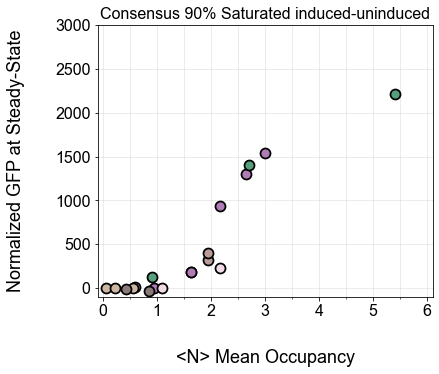

In [36]:
dir1 = 'in-vitro_fits_plots'
dir2 = 'Zif268'
dir3 = '1par_statmech_predicted'

df_NtoGE = load_obj(os.path.join(dir1,dir2,dir3,'df_NtoGE_induced-uninduced'))
plot_config = dict(
    df = df_NtoGE,
    figsize = (6,5),
    yscale = 'linear',
    xlabel = '<N> Mean Occupancy',
    ylabel = 'Normalized GFP at Steady-State',
    xmajorticks = [0,1,2,3,4,5,6],
    xminorticks = [0.5,1.0,1.5,2,2.5,3,3.5,4,4.5,5,5.5],
    ymajorticks = [0, 500, 1000, 1500, 2000, 2500, 3000],
    xtickformat = '%g',
    ytickformat = '%g',
    consensusOcc = 0.9,
    status = 'induced_diff',
    xlim = [-0.1,6.1],
    ylim = [-100, 3000],
    colors = {'NS':'k', '1V':'#CBB6A2', '1S':'#579E7C', '1W':'#AF7CB5', '3V':'#CBB6A2', '3W':'#AF7CB5', '6V':'#CBB6A2', '6W':'#AF7CB5','2W':'#AF7CB5','4W':'#AF7CB5','5W':'#AF7CB5',"3V'":'#897A77',"6V'":'#897A77','3VW':'#EFDAE6','6VW':'#EFDAE6','3S':'#579E7C','6S':'#579E7C','3W3V':'#B79C97',"3W'":'#AF7CB5',"3W3V'":'#B79C97'},
    xscale = 'linear',
    title = 'Consensus 90% Saturated induced-uninduced',
    saveas = os.path.join(dir1,dir2,dir3,'meanOcc_GFPss_0.90_induced-uninduced'))

plot_meanOcc_vs_GEout(plot_config)

#### Gene expression as a function of mean occupancy < N >, induced-uninduced, cons. occ = 0.95

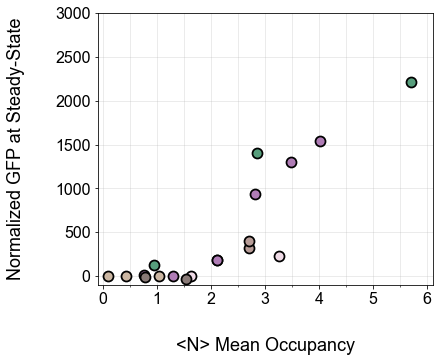

In [37]:
dir1 = 'in-vitro_fits_plots'
dir2 = 'Zif268'
dir3 = '1par_statmech_predicted'

df_NtoGE = load_obj(os.path.join(dir1,dir2,dir3,'df_NtoGE_induced-uninduced'))
plot_config = dict(
    df = df_NtoGE,
    figsize = (6,5),
    yscale = 'linear',
    xlabel = '<N> Mean Occupancy',
    ylabel = 'Normalized GFP at Steady-State',
    xmajorticks = [0,1,2,3,4,5,6],
    xminorticks = [0.5,1.0,1.5,2,2.5,3,3.5,4,4.5,5,5.5],
    ymajorticks = [0, 500, 1000, 1500, 2000, 2500, 3000],
    xtickformat = '%g',
    ytickformat = '%g',
    consensusOcc = 0.95,
    status = 'induced_diff',
    xlim = [-0.1,6.1],
    ylim = [-100, 3000],
    colors = {'NS':'k', '1V':'#CBB6A2', '1S':'#579E7C', '1W':'#AF7CB5', '3V':'#CBB6A2', '3W':'#AF7CB5', '6V':'#CBB6A2', '6W':'#AF7CB5','2W':'#AF7CB5','4W':'#AF7CB5','5W':'#AF7CB5',"3V'":'#897A77',"6V'":'#897A77','3VW':'#EFDAE6','6VW':'#EFDAE6','3S':'#579E7C','6S':'#579E7C','3W3V':'#B79C97',"3W'":'#AF7CB5',"3W3V'":'#B79C97'},
    xscale = 'linear',
    title = '',
    saveas = os.path.join(dir1,dir2,dir3,'meanOcc_GFPss_0.95_induced-uninduced'))

plot_meanOcc_vs_GEout(plot_config)

#### Gene expression as a function of mean occupancy < N >, induced-uninduced, cons. occ = 0.85

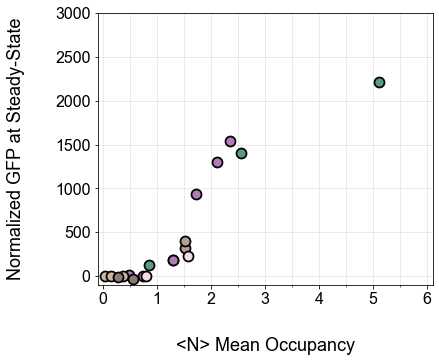

In [38]:
dir1 = 'in-vitro_fits_plots'
dir2 = 'Zif268'
dir3 = '1par_statmech_predicted'

df_NtoGE = load_obj(os.path.join(dir1,dir2,dir3,'df_NtoGE_induced-uninduced'))
plot_config = dict(
    df = df_NtoGE,
    figsize = (6,5),
    yscale = 'linear',
    xlabel = '<N> Mean Occupancy',
    ylabel = 'Normalized GFP at Steady-State',
    xmajorticks = [0,1,2,3,4,5,6],
    xminorticks = [0.5,1.0,1.5,2,2.5,3,3.5,4,4.5,5,5.5],
    ymajorticks = [0, 500, 1000, 1500, 2000, 2500, 3000],
    xtickformat = '%g',
    ytickformat = '%g',
    consensusOcc = 0.85,
    status = 'induced_diff',
    xlim = [-0.1,6.1],
    ylim = [-100, 3000],
    colors = {'NS':'k', '1V':'#CBB6A2', '1S':'#579E7C', '1W':'#AF7CB5', '3V':'#CBB6A2', '3W':'#AF7CB5', '6V':'#CBB6A2', '6W':'#AF7CB5','2W':'#AF7CB5','4W':'#AF7CB5','5W':'#AF7CB5',"3V'":'#897A77',"6V'":'#897A77','3VW':'#EFDAE6','6VW':'#EFDAE6','3S':'#579E7C','6S':'#579E7C','3W3V':'#B79C97',"3W'":'#AF7CB5',"3W3V'":'#B79C97'},
    xscale = 'linear',
    title = '',
    saveas = os.path.join(dir1,dir2,dir3,'meanOcc_GFPss_0.85_induced-uninduced'))

plot_meanOcc_vs_GEout(plot_config)

#### Gene expression as a function of mean occupancy < N >, induced

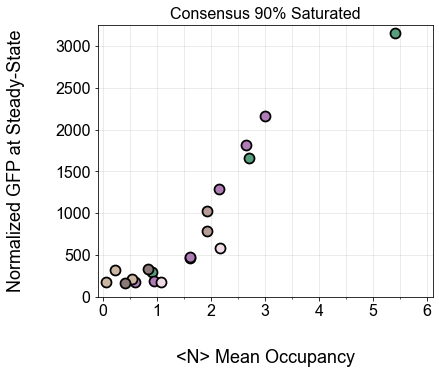

In [40]:
dir1 = 'in-vitro_fits_plots'
dir2 = 'Zif268'
dir3 = '1par_statmech_predicted'

df_NtoGE = load_obj(os.path.join(dir1,dir2,dir3,'df_NtoGE'))
plot_config = dict(
    df = df_NtoGE,
    figsize = (6,5),
    yscale = 'linear',
    xlabel = '<N> Mean Occupancy',
    ylabel = 'Normalized GFP at Steady-State',
    xmajorticks = [0,1,2,3,4,5,6],
    xminorticks = [0.5,1.0,1.5,2,2.5,3,3.5,4,4.5,5,5.5],
    ymajorticks = [0, 500, 1000, 1500, 2000, 2500, 3000],
    xtickformat = '%g',
    ytickformat = '%g',
    consensusOcc = 0.90,
    status = 'induced',
    xlim = [-0.1,6.1],
    ylim = [0, 3250],
    colors = {'NS':'k', '1V':'#CBB6A2', '1S':'#579E7C', '1W':'#AF7CB5', '3V':'#CBB6A2', '3W':'#AF7CB5', '6V':'#CBB6A2', '6W':'#AF7CB5','2W':'#AF7CB5','4W':'#AF7CB5','5W':'#AF7CB5',"3V'":'#897A77',"6V'":'#897A77','3VW':'#EFDAE6','6VW':'#EFDAE6','3S':'#579E7C','6S':'#579E7C','3W3V':'#B79C97',"3W'":'#AF7CB5',"3W3V'":'#B79C97'},
    xscale = 'linear',
    title = 'Consensus 90% Saturated',
    saveas = os.path.join(dir1,dir2,dir3,'meanOcc_GFPss_induced_0.90'))

plot_meanOcc_vs_GEout(plot_config)

#### Measured vs Predicted < N > for targets characterized in vitro

Rsq:  0.9961121807950863
[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 9
    # variables        = 1
    chi-square         = 0.02789177
    reduced chi-square = 0.00348647
    Akaike info crit   = -49.9898341
    Bayesian info crit = -49.7926095
[[Variables]]
    m:  0.91893714 +/- 0.01165296 (1.27%) (init = 1)
    b:  0 (fixed)


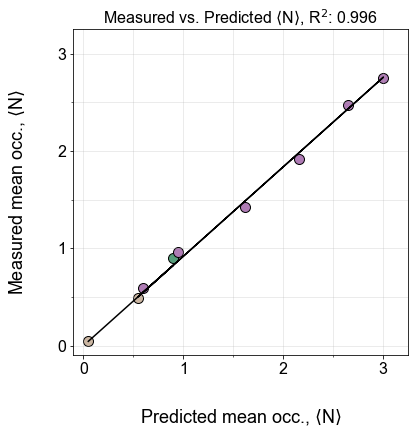

In [42]:
dir1 = 'in-vitro_fits_plots'
dir2 = os.path.join('Zif268','plots')

df_NtoGE = load_obj(os.path.join(dir1,dir2,'1par_statmech_predicted','df_NtoGE_induced-uninduced'))
df_NtoGE_measured = load_obj(os.path.join(dir1,dir2,'1par_statmech_measured','df_NtoGE_measured'))

plot_config = dict(
    df_predicted = df_NtoGE,
    df_measured = df_NtoGE_measured,
    figsize = (6,6),
    yscale = 'linear',
    xlabel = 'Predicted mean occ., ' + r"$\langle$"+ "N"+ r"$\rangle$",
    ylabel = 'Measured mean occ., ' + r"$\langle$"+ "N"+ r"$\rangle$",
    xmajorticks = [0,1,2,3,4,5,6],
    xminorticks = [0.5,1.0,1.5,2,2.5,3],
    ymajorticks = [0,1,2,3,4,5,6],
    yminorticks = [0.5,1.0,1.5,2,2.5,3],
    xtickformat = '%g',
    ytickformat = '%g',
    consensusOcc = 0.90,
    xlim = [-0.1,3.25],
    ylim = [-0.1,3.25],
    colors = {'NS':'k', '1V':'#CBB6A2', '1S':'#579E7C', '1W':'#AF7CB5', 
              '3V':'#CBB6A2', '3W':'#AF7CB5', '6V':'#CBB6A2', '6W':'#AF7CB5',
              '2W':'#AF7CB5','4W':'#AF7CB5','5W':'#AF7CB5',"3V'":'#897A77',
              "6V'":'#897A77','3VW':'#EFDAE6','6VW':'#EFDAE6','3S':'#579E7C',
              '6S':'#579E7C','3W3V':'#B79C97',"3W'":'#AF7CB5',"3W3V'":'#B79C97'},
    xscale = 'linear',
    title = 'Measured vs. Predicted '+r"$\langle$"+ "N"+ r"$\rangle$",
    saveas = os.path.join(dir1,dir2,'measured_vs_predicted_meanOccs'))

plot_measured_vs_predicted(plot_config)

# Further SBC, Hill, and Statmech. binding models, fits, and plots

### Determine parameters of SBC model consistent with the data

#### Path

In [31]:
dir1 = 'in-vitro_fits_plots'
dir2 = 'Zif268'
dir3 = 'SBC'
path = os.path.join(dir1,dir2,dir3)

#### MCMC SBC

In [32]:
def sbc(x, a=1, lk=1):
    return a * x / (x + 10**(lk)) 

In [35]:
sbcmodel = Model(sbc)
xs = np.logspace(0, 3.5, 200)

params_df = pd.DataFrame()
ptiles_df = pd.DataFrame()

ptiles = range(0,101)

for tgt, tgtgrp in fdf.groupby('TgtName'):
    print(tgt)

    tgtgrp = tgtgrp.loc[(tgtgrp['Free_nM']>0)&(tgtgrp['Complex']>0)] 
    xd, yd = (tgtgrp['Free_nM'], tgtgrp['Complex']) 

    params = []

    params = sbcmodel.make_params(a=0.6758, lk=2)
    params['a'].min = 0
    params['a'].max = 7
    if tgt in ['W1XXXXX','W2XXXXX','W3XXXXX','W4XXXXX']: # Fix Bmax (to the occupancy calibration factor) for these weak targets since binding doesn't saturate
        params['a'].vary = False

    params['lk'].min = 0
    params['lk'].max = 4

    result = sbcmodel.fit(yd, params, x=xd)

    emcee_kws = dict(steps=10000, burn=300, thin=10, is_weighted=False, progress=True)
    emcee_params = result.params.copy()
    emcee_params['a'].max = result.params['a']*1.75
    result_emcee = sbcmodel.fit(yd, emcee_params, x=xd, method='emcee', fit_kws=emcee_kws)
    result_emcee.col_deriv = None # lmfit has a bug and fails to set this parameter. The model can't be saved without it being set!

    rps = result_emcee.params 
    np.savetxt(os.path.join(path,'{}_flatchain_sbc.csv'.format(tgt)), result_emcee.flatchain, delimiter=',') #save chain
    lm.model.save_modelresult(rps, os.path.join(path,'{}_fitresult_sbc.model'.format(tgt))) 

    paramsCalcRsq = []

    # feed the .fit (emcee) params back into .fit to obtain goodness-of-fit stats 
    # this is a workaround because lmfit's emcee-fitting doesn't output useful residual stats
    paramsCalcRsq = sbcmodel.make_params(a=rps['a'].value,lk=rps['lk'].value)
    paramsCalcRsq['a'].vary=False
    paramsCalcRsq['lk'].vary=False
    result_fit_report = sbcmodel.fit(yd, paramsCalcRsq, x=xd)

    Rsq = 1 - result_fit_report.residual.var() / np.var(yd)

    #Create dataframe of parameters
    d = result_emcee.params.valuesdict()
    d['tgt'] = tgt
    d['Rsq'] = Rsq
    params_df = pd.concat([params_df, pd.DataFrame(d, index=[0])])

    #Create dataframe of percentiles
    pp = result_emcee.flatchain.apply(np.percentile, args=[ptiles])
    pp['tgt'] = tgt
    pp['ptile'] = ptiles     
    ptiles_df = pd.concat([ptiles_df, pp])

    fig = plt.figure(figsize=(4,6))
    gs = fig.add_gridspec(2, 1)
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[1,0])
    ax1.plot(xs, result.eval(params=result_emcee.params, x=xs))
    ax1.plot(xd, yd, 'k.') # plot datapoits for that target
    result_emcee.plot_residuals(ax=ax2)

    for ax in (ax1, ax2):
        ax.set_xscale('log')
        ax.set_xlim([1e0, 3e3])
    ax2.set_xlabel('Free TF (nM)')
    ax1.set_ylabel('DNA-TF complex (a.u.)')
    ax2.set_ylabel('Residual')

    ax1.set_title("{} R\u00b2={:.2f}\na={:.2f} | k={:.2f}".format(tgt, Rsq, rps['a'].value, 10**rps['lk'].value))
    ax2.set_title(None)
    plt.tight_layout()
    plt.savefig(os.path.join(path,"{}_fit_sbc.png".format(tgt)), dpi=200)

    plt.clf()
    
    if tgt in ['W1XXXXX','W2XXXXX','W3XXXXX','W4XXXXX']:
        continue
    emcee_corner = corner.corner(result_emcee.flatchain, labels=result_emcee.var_names, truths=list(result_emcee.params.valuesdict().values()))
    plt.savefig(os.path.join(path,'{}_corner_sbc.png'.format(tgt)), dpi=200)
    plt.close('all')

params_df.reset_index(drop=True, inplace=True)
params_df.set_index('tgt', drop=True, inplace=True)
params_df['k'] = 10**params_df['lk']
params_df.to_csv(os.path.join(path,'fit_params_sbc.csv'))
ptiles_df = ptiles_df.set_index(['tgt', 'ptile'])
ptiles_df['k'] = 10**params_df['lk']
ptiles_df.to_csv(os.path.join(path,'fit_params_percentiles_sbc.csv'))

#### Fit the # site data to get an occupancy calibration

In [38]:
tgts = ['M1XXXXX', 'M1M2XXXX', 'M1M2M3XXX', 'M1M2M3M4XX', 'M1M2M3M4M5X', 'M1M2M3M4M5M6']

params_df = pd.read_csv(os.path.join(path,'fit_params_sbc.csv'), index_col=0)
ptiles_df = pd.read_csv(os.path.join(path,'fit_params_percentiles_sbc.csv'), index_col=[0,1])

p = 'a'
x = np.array([1, 2, 3, 4, 5, 6])
y = params_df.loc[tgts, p]
ptiles = [5, 95]
yerr = np.vstack((y - ptiles_df.loc[[(tgt, ptiles[0]) for tgt in tgts]][p].values, ptiles_df.loc[[(tgt, ptiles[1]) for tgt in tgts]][p].values - y))

def proportional(x, m):
    return x*m

pmodel = Model(proportional)
params = pmodel.make_params(m=0.7)
result = pmodel.fit(y, params, x=x)
    
emcee_kws = dict(steps=10000, burn=300, thin=10, is_weighted=False, progress=True)
emcee_params = result.params.copy()
result_emcee = pmodel.fit(y, emcee_params, x=x, method='emcee', fit_kws=emcee_kws)
result_emcee.col_deriv = None # lmfit has a bug and fails to set this parameter. The model can't be saved without it being set!

rps = result_emcee.params
np.savetxt(os.path.join(path,'occupancy_calibration_flatchain_sbc.csv'.format(tgt)), result_emcee.flatchain, delimiter=',')
lm.model.save_modelresult(rps, os.path.join(path,'occupancy_calibration_fitresult_sbc.model'.format(tgt)))

d = result_emcee.params.valuesdict()
d['tgt'] = tgt

fig = plt.figure(figsize=(4,6))
gs = fig.add_gridspec(2, 1)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
xs = x
ax1.plot(xs, result.eval(params=rps, x=xs))
ax1.errorbar(x, y, yerr=yerr, fmt='k.')
result_emcee.plot_residuals(ax=ax2)

ax2.set_xlabel('# sites')
ax1.set_ylabel('a, occ. at saturation')
ax2.set_ylabel('Residual')

lower, upper = np.percentile(result_emcee.flatchain['m'], [5, 95])
ax1.set_title("Occupancy calibration\n$m=%.4f^{+%.4f}_{-%.4f}$" % (rps['m'].value, upper-rps['m'].value, rps['m'].value-lower))
ax2.set_title(None)
plt.tight_layout()
plt.savefig(os.path.join(path,"occupancy_calibration_fit_sbc.png".format(tgt)), dpi=200)

plt.clf()
emcee_corner = corner.corner(result_emcee.flatchain, labels=result_emcee.var_names, truths=list(result_emcee.params.valuesdict().values()))

plt.savefig(os.path.join(path,'occupancy_calibration_corner_sbc.png'.format(tgt)), dpi=200)
plt.close('all')

100%|██████████| 10000/10000 [03:50<00:00, 43.38it/s]


#### SBC: Update the fit plots to include a sampling of the posterior distribution

In [40]:
# Sample the flatchain and produce and return simulated results
def eval_samples(flatchain, model, x, N):
    
    fc = flatchain
    
    results = np.zeros([len(x), N])
    params_all = []
    inds = np.random.randint(low=int(0.1*len(fc)), high=len(fc), size=N)
    for i,ind in enumerate(inds):
        sample = fc[ind]
        params_all.append(sample)
        params = lm.Parameters() 
        if len(sample) == 3:
            params.add_many(('a', sample[0]), ('lk', sample[1]), ('_lnsigma', sample[2])) #store the sample parameters
        elif len(sample) == 2:
            params.add_many(('a', sample[0]), ('lk', sample[1]))
        results[:, i] = model.eval(x=x, params=params) #for each x, determine the occupancy
    return {'sims': results, 'params': np.array(params_all)}

In [41]:
xs = np.logspace(-1,5,301)
N=300
sbcmodel = Model(sbc)
cal_factor = 0.6758

params_df = pd.read_csv(os.path.join(path,'fit_params_sbc.csv'), index_col=0)
ptiles_df = pd.read_csv(os.path.join(path,'fit_params_percentiles_sbc.csv'), index_col=[0,1])

for tgt, tgtgrp in fdf.groupby('TgtName'):
    if tgt in params_df.index :
    
        print(tgt)

        tgtgrp = tgtgrp.loc[(tgtgrp['Free_nM']>0)&(tgtgrp['Complex']>0)]
        xd, yd = (tgtgrp['Free_nM'], tgtgrp['Complex'])

        fc = np.loadtxt(os.path.join(path,'{}_flatchain_sbc.csv'.format(tgt)), delimiter=',')

        results = eval_samples(fc, sbcmodel, xs, N)
        sims = results['sims'] # every x value is evaluated for every paramter set
        params = results['params'] # sample parameter sets
        lower, upper = np.percentile(sims, [5, 95], axis=1)

        np.savetxt(os.path.join(path,'{}_posterior_sims_sbc.csv'.format(tgt)), sims)
        np.savetxt(os.path.join(path,'{}_posterior_sim_params_sbc.csv'.format(tgt)), params)

        plt.figure(figsize=(5,5))
        plt.fill_between(xs, lower / cal_factor, upper / cal_factor, color='gray', alpha=0.3)
        plt.plot(xd, yd / cal_factor, '.')

        plt.xlim([1e0, 2e3])
        plt.xscale('log')
        plt.xlabel('TF concentration (nM)')
        plt.ylabel('<N>, Mean occupancy')

        val_Bmax = params_df.loc[tgt, 'a'] / cal_factor
        lower_Bmax, upper_Bmax = np.percentile(fc[:,0], [5, 95]) / cal_factor
        val_k = 10**params_df.loc[tgt, 'lk']
        lower_k, upper_k = 10**np.percentile(fc[:,1], [5, 95])
        plt.title("Zif268 | %s \n$Bmax\'=%.2f^{+%.2f}_{-%.2f}$, $k=%.1f^{+%.1f}_{-%.1f}$" % \
            (tgt,
             val_Bmax, upper_Bmax-val_Bmax, val_Bmax-lower_Bmax,
             val_k, upper_k-val_k, val_k-lower_k))
        plt.tight_layout()
        plt.savefig(os.path.join(path,"{}_fit_samples_sbc.png".format(tgt)), dpi=200)
        plt.clf()
        plt.close('all')

(17)A11(-1)A11(-1)A11(-1)A11(40)
(17)A11(-1)A11(-1)A11(48)
(17)A11(-1)A11(56)
(17)A11(-3)A11(-3)A11(-3)A11(-3)A11(-3)A11(-3)A11(-3)A11(-3)A11(16)
(17)A11(-3)A11(-3)A11(-3)A11(-3)A11(-3)A11(-3)A11(-3)A11(22)
(17)A11(-3)A11(-3)A11(-3)A11(-3)A11(-3)A11(34)
(17)A11(-3)A11(-3)A11(-3)A11(46)
(17)A11(-3)A11(-3)A11(52)
(17)A11(-3)A11(58)
(17)A11(-3)A5(-3)A11(52)
(17)A11(-3)A5(58)
(17)A11(-3)A95(-3)A11(52)
(17)A11(-3)M5(-3)A11(52)
(17)A11(-3)M5(58)
(17)A11(-3)W4(-3)A11(52)
(17)A11(-3)W4(58)
(17)A4(-3)A6(-3)A4(52)
(17)A4(-3)A6(58)
(17)A5(-1)A11(-1)A5(48)
(17)A5(-3)A11(-3)A5(52)
(17)A5(-3)M5(-3)A5(52)
(17)A6(-3)A4(-3)A6(52)
(17)A6(-3)A4(58)
(17)A6(-3)M5(58)
(17)A7(-3)A11(-3)A9(52)
(17)A7(-3)M4(-3)A10(52)
(17)A7(-3)M5(-3)A9(52)
(17)A95(-1)A11(-1)A95(48)
(17)A95(-3)A11(-3)A95(52)
(17)M1(-1)M2(56)
(17)M1(-3)M2(-3)M3(-3)M4(46)
(17)M1(-3)M2(-3)M3(52)
(17)M1(-3)M2(58)
(17)M5(-1)A11(-1)M5(48)
(17)M5(-1)M5(-1)M5(-1)M5(40)
(17)M5(-1)M5(-1)M5(48)
(17)M5(-1)M5(56)
(17)M5(-3)A11(-3)M5(52)
(17)M5(-3)A5(-3)M5(

#### plot the Fig.2 multi-site plots

In [42]:
dir1 = 'in-vitro_fits_plots'
dir2 = 'Zif268'
dir3 = 'SBC'
path = os.path.join(dir1,dir2,dir3)

A11XXXXX
M1M2M3M4M5M6
M1M2M3M4M5X
M1M2M3M4XX
M1M2M3XXX
M1M2XXXX
M1XXXXX
XXXXXX


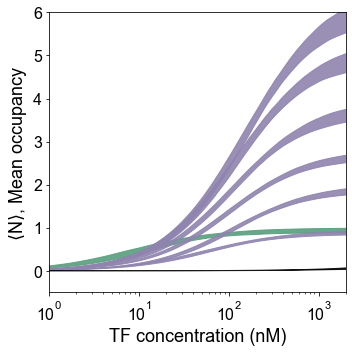

In [45]:
def sbc(x, a=1, lk=1):
    return a * x / (x + 10**(lk)) 

xs = np.logspace(-1,5,301)
N=300
cal_factor = 0.6758 
sbcmodel = Model(sbc)

params_df = pd.read_csv(os.path.join(path,'fit_params_sbc.csv'), index_col=0)
ptiles_df = pd.read_csv(os.path.join(path,'fit_params_percentiles_sbc.csv'), index_col=[0,1])

tgts = ['M1XXXXX','M1M2XXXX','M1M2M3XXX','M1M2M3M4XX','M1M2M3M4M5X','M1M2M3M4M5M6', 'A11XXXXX','XXXXXX']
labels = ['1 Strong TFBS','6 Weak TFBS','5 Weak TFBS','4 Weak TFBS','3 Weak TFBS','2 Weak TFBS', '1 Weak TFBS', 'Nonspecific']

colors = ['#579E7C', '#8F84AE','#8F84AE', '#8F84AE', '#8F84AE', '#8F84AE', '#8F84AE', 'k']
i=0

plt.figure(figsize=(5,5))

for tgt, tgtgrp in fdf.groupby('TgtName'):
    
    if tgt in tgts:
        print(tgt)
        
        tgtgrp = tgtgrp.loc[(tgtgrp['Free_nM']>0)&(tgtgrp['Complex']>0)]
        xd, yd = (tgtgrp['Free_nM'], tgtgrp['Complex'])
        
        fc = np.loadtxt(os.path.join(path,'{}_flatchain_sbc.csv'.format(tgt)), delimiter=',')

        sims = np.loadtxt(os.path.join(path,'{}_posterior_sims_sbc.csv'.format(tgt)))
        params = np.loadtxt(os.path.join(path,'{}_posterior_sim_params_sbc.csv'.format(tgt)))

        lower, upper = np.percentile(sims, [5, 95], axis=1)
        
        plt.fill_between(xs, lower / cal_factor, upper / cal_factor, color=colors[i], alpha=0.9, label=labels[i])
#         plt.plot(xd, yd / cal_factor, '.', color=colors[i])
        
        plt.xlim([1e0, 2e3])
        plt.ylim([-0.5,6])
        plt.xscale('log')
        plt.xlabel('TF concentration (nM)',fontsize=18)
        plt.ylabel(r"$\langle$"+ "N"+ r"$\rangle$"+', Mean occupancy',fontsize=18)
        plt.tight_layout()
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        
        i=i+1
# plt.legend(loc = 'upper left')
plt.savefig(os.path.join(dir1,dir2,'plots','multi_site_plot_without6xVW_woLegend.svg'.format(tgt)), dpi=300)
plt.savefig(os.path.join(dir1,dir2,'plots','multi_site_plot_without6xVW_woLegend.png'.format(tgt)), dpi=300)
plt.savefig(os.path.join(dir1,dir2,'plots','multi_site_plot_without6xVW_woLegend.jpg'.format(tgt)), dpi=300)

plt.show()                

A11XXXXX
M1M2M3M4M5M6
W2W3W1W4W3W2
XXXXXX


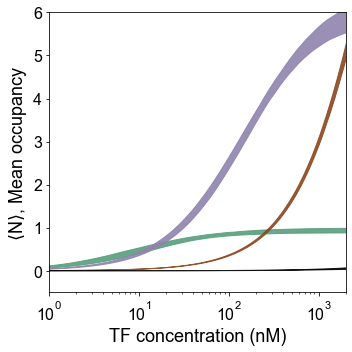

In [47]:
def sbc(x, a=1, lk=1):
    return a * x / (x + 10**(lk)) 

xs = np.logspace(-1,5,301) #note: logspace so -1 = 10^-1 = 1/10
N=300
cal_factor = 0.6758 
sbcmodel = Model(sbc)

params_df = pd.read_csv(os.path.join(path,'fit_params_sbc.csv'), index_col=0)
ptiles_df = pd.read_csv(os.path.join(path,'fit_params_percentiles_sbc.csv'), index_col=[0,1])

tgts = ['M1M2M3M4M5M6', 'A11XXXXX', 'W2W3W1W4W3W2','XXXXXX']
labels = ['1 Strong TFBS','6 Weak TFBS','6 Very-weak TFBS', 'Nonspecific']

colors = ['#579E7C', '#8F84AE','#8B4820', 'k']
i=0

plt.figure(figsize=(5,5))

for tgt, tgtgrp in fdf.groupby('TgtName'):
    
    if tgt in tgts:
        print(tgt)
        
        tgtgrp = tgtgrp.loc[(tgtgrp['Free_nM']>0)&(tgtgrp['Complex']>0)]
        xd, yd = (tgtgrp['Free_nM'], tgtgrp['Complex'])
        
        fc = np.loadtxt(os.path.join(path,'{}_flatchain_sbc.csv'.format(tgt)), delimiter=',')

        sims = np.loadtxt(os.path.join(path,'{}_posterior_sims_sbc.csv'.format(tgt)))
        params = np.loadtxt(os.path.join(path,'{}_posterior_sim_params_sbc.csv'.format(tgt)))

        lower, upper = np.percentile(sims, [5, 95], axis=1)
        
        plt.fill_between(xs, lower / cal_factor, upper / cal_factor, color=colors[i], alpha=0.9, label=labels[i])
#         plt.plot(xd, yd / cal_factor, '.', color=colors[i])
        
        plt.xlim([1e0, 2e3])
        plt.ylim([-0.5,6])
        plt.xscale('log')
        plt.xlabel('TF concentration (nM)',fontsize=18)
        plt.ylabel(r"$\langle$"+ "N"+ r"$\rangle$"+', Mean occupancy',fontsize=18)
        plt.tight_layout()
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)

        
        i=i+1
# plt.legend(loc = 'upper left')
plt.savefig(os.path.join(dir1,dir2,'plots','multi_site_plot_6xW_minimal_woLegend.svg'.format(tgt)), dpi=300)
plt.savefig(os.path.join(dir1,dir2,'plots','multi_site_plot_6xW_minimal_woLegend.jpg'.format(tgt)), dpi=300)
plt.savefig(os.path.join(dir1,dir2,'plots','multi_site_plot_6xW_minimal_woLegend.png'.format(tgt)), dpi=300)

plt.show()                

#### Calculate the cross point between strong site targets and multi low-affinity targets

In [51]:
def calculate_crosspoints_SBC(tgtlist, strong_tgtname, params_df, directory='', subdirectory=''):
    """
    this method takes as input a params_df, as well as a list of targets, and the target name for which
    to calculate cross points against. It assumes that the fitting was done using a saturation binding curve
    model: Y = Bmax * x/(x+Kd)
    
    
    """
    Bmax_s = params_df.loc[strong_tgtname,'a']
    Kd_s = 10**params_df.loc[strong_tgtname,'lk']
    
    Bmax_tgts = params_df.loc[tgtlist,'a'].values
    Kd_tgts = 10**params_df.loc[tgtlist,'lk'].values
    
    crosspoints = []
    
    for i in range(len(tgtlist)):
        x = Symbol('x')
        
        eqn = Bmax_s*x/(x+Kd_s) - Bmax_tgts[i]*x/(x+Kd_tgts[i])
        crosspoints.append(solve(eqn, x)[1][0])
    
    return crosspoints

In [54]:
params_df = pd.read_csv(os.path.join(path,'fit_params_sbc.csv'), index_col=0)
ptiles_df = pd.read_csv(os.path.join(path,'fit_params_percentiles_sbc.csv'), index_col=[0,1])
ptiles_df['kd']=10**ptiles_df.loc[:,'lk']

tgts = ['M1M2XXXX','M1M2M3XXX','M1M2M3M4XX','M1M2M3M4M5X','M1M2M3M4M5M6', 'W2W3W1W4W3W2']
strongtgt = ['A11XXXXX']

crosspoints = calculate_crosspoints_SBC(tgtlist=tgts, strong_tgtname=strongtgt, params_df=params_df)

crosspointsdf = pd.DataFrame({'crosspoint': crosspoints}, index=tgts)

crosspointsdf.to_csv(os.path.join(path,'crosspoints.csv'))

### Alternate model: determine parameters of Hill functions consistent with the data

In [13]:
dir1 = 'in-vitro_fits_plots'
dir2 = 'Zif268'
dir3 = 'Hill'
path = os.path.join(dir1,dir2,dir3)

In [10]:
def hill(x, Bmax=1, n=1, lk=1):
    return Bmax * x**n / (x**n + 10**(n*lk)) 

In [11]:
hmodel = Model(hill)
xs = np.logspace(0, 3.5, 200)

params_df = pd.DataFrame() # Initialize dataframe to store model parameters sequentially for each target

for tgt, tgtgrp in fdf.groupby('TgtName'):
    print(tgt)
    
    tgtgrp = tgtgrp.loc[(tgtgrp['Free_nM']>0)&(tgtgrp['Complex']>0)] 
    xd, yd = (tgtgrp['Free_nM'], tgtgrp['Complex']) 
    
    params = hmodel.make_params(Bmax=0.5, n=1, lk=2) # initialize parameters
    params['Bmax'].min = 0
    params['Bmax'].max = 7
    params['n'].min = 0
    params['n'].max = 10
    params['lk'].min = 0
    params['lk'].max = 4
    
    result = hmodel.fit(yd, params, x=xd) # Initial fit
    
    emcee_kws = dict(steps=10000, burn=300, thin=10, is_weighted=False, progress=True)
    emcee_params = result.params.copy()
    emcee_params['Bmax'].max = result.params['Bmax']*1.5
    result_emcee = hmodel.fit(yd, emcee_params, x=xd, method='emcee', fit_kws=emcee_kws) # MCMC
    result_emcee.col_deriv = None # lmfit has a bug and fails to set this parameter. The model can't be saved without it being set!
    
    rps = result_emcee.params 
    np.savetxt(os.path.join(path,'{}_flatchain_Hill.csv'.format(tgt)), result_emcee.flatchain, delimiter=',') #save chain
    lm.model.save_modelresult(rps, os.path.join(path,'{}_fitresult_Hill.model'.format(tgt))) #save model results
    
    d = result_emcee.params.valuesdict()
    d['tgt'] = tgt
    params_df = pd.concat([params_df, pd.DataFrame(d, index=[0])])
    
    fig = plt.figure(figsize=(4,6)) # Plotting model fit and residuals
    gs = fig.add_gridspec(2, 1)
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[1,0])
    ax1.plot(xs, result.eval(params=result_emcee.params, x=xs)) 
    ax1.plot(xd, yd, 'k.') # plot datapoints
    result_emcee.plot_residuals(ax=ax2) 
    
    for ax in (ax1, ax2):
        ax.set_xscale('log')
        ax.set_xlim([1e0, 2e3])
    ax2.set_xlabel('Free TF (nM)')
    ax1.set_ylabel('DNA-TF complex (a.u.)')
    ax2.set_ylabel('Residual')
    
    ax1.set_title("{}\nBmax={:.2f} | n = {:.2f} | k={:.2f}".format(tgt, rps['Bmax'].value, rps['n'].value, 10**rps['lk'].value))
    ax2.set_title(None)
    plt.tight_layout()
    plt.savefig(os.path.join(path,"{}_fit_Hill.png".format(tgt)), dpi=200)
#     plt.show()
                              
    plt.clf()
    emcee_corner = corner.corner(result_emcee.flatchain, labels=result_emcee.var_names, truths=list(result_emcee.params.valuesdict().values())) # Plot corner plot
#     plt.show()
    plt.savefig(os.path.join(path,'{}_corner_Hill.png'.format(tgt)), dpi=200)
    plt.close('all')

params_df.reset_index(drop=True, inplace=True)
params_df.set_index('tgt', drop=True, inplace=True)
params_df.to_csv(os.path.join(path,'fit_params_Hill.csv'))

(17)A11(-1)A11(-1)A11(-1)A11(40)


100%|██████████| 40/40 [00:03<00:00, 12.68it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.31617641 4.1736148  4.3119741  4.23423142]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)A11(-1)A11(-1)A11(48)


100%|██████████| 40/40 [00:03<00:00, 12.31it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [3.82296471 4.04832821 4.18827675 3.96280496]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)A11(-1)A11(56)


100%|██████████| 40/40 [00:03<00:00, 12.38it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.43063382 4.31462027 4.17001683 4.16582073]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)A11(-3)A11(-3)A11(-3)A11(-3)A11(-3)A11(-3)A11(-3)A11(-3)A11(16)


100%|██████████| 40/40 [00:03<00:00, 11.80it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.03735354 4.15246571 4.00168236 4.18784581]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)A11(-3)A11(-3)A11(-3)A11(-3)A11(-3)A11(-3)A11(-3)A11(22)


100%|██████████| 40/40 [00:03<00:00, 11.69it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.15926759 4.24051205 4.23892298 4.55840479]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)A11(-3)A11(-3)A11(-3)A11(-3)A11(-3)A11(34)


100%|██████████| 40/40 [00:03<00:00, 11.52it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.50567237 4.10943795 4.02049287 4.01282523]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)A11(-3)A11(-3)A11(-3)A11(46)


100%|██████████| 40/40 [00:03<00:00, 12.07it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [3.95906933 4.12904174 4.05820222 4.15481352]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)A11(-3)A11(-3)A11(52)


100%|██████████| 40/40 [00:03<00:00, 11.99it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.23120488 4.30715119 4.33659605 4.13640436]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)A11(-3)A11(58)


100%|██████████| 40/40 [00:03<00:00, 12.23it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.40228983 4.18389269 4.33090659 4.204253  ]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)A11(-3)A5(-3)A11(52)


100%|██████████| 40/40 [00:03<00:00, 11.00it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.01576094 4.22140886 4.02367513 4.36376115]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)A11(-3)A5(58)


100%|██████████| 40/40 [00:03<00:00, 12.09it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.34963647 4.26368979 4.24515337 4.31758824]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)A11(-3)A95(-3)A11(52)


100%|██████████| 40/40 [00:03<00:00, 10.51it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.23388418 4.26112233 4.3028009  4.06452788]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)A11(-3)M5(-3)A11(52)


100%|██████████| 40/40 [00:03<00:00, 11.26it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.21127264 4.10796708 4.17043649 3.95376196]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)A11(-3)M5(58)


100%|██████████| 40/40 [00:03<00:00, 12.32it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.26539136 4.32231109 4.30470177 4.07993866]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)A11(-3)W4(-3)A11(52)


100%|██████████| 40/40 [00:03<00:00, 11.27it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [3.86596469 4.08148514 4.08663612 4.01904725]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)A11(-3)W4(58)


100%|██████████| 40/40 [00:03<00:00, 12.65it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.51765943 4.14859232 4.3253902  4.24875772]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)A4(-3)A6(-3)A4(52)


100%|██████████| 40/40 [00:03<00:00, 11.95it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.38075192 4.39996429 4.10570347 4.36628231]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)A4(-3)A6(58)


100%|██████████| 40/40 [00:03<00:00, 10.08it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.2844421  4.09556265 4.31604906 3.94527466]


(17)A5(-1)A11(-1)A5(48)


100%|██████████| 40/40 [00:05<00:00,  7.64it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.15491294 4.26287658 4.26624659 4.32691565]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)A5(-3)A11(-3)A5(52)


100%|██████████| 40/40 [00:05<00:00,  7.87it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.13598214 4.29143374 4.15088635 4.07072644]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)A5(-3)M5(-3)A5(52)


100%|██████████| 40/40 [00:04<00:00,  8.97it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.18641415 4.4122315  4.00012283 4.20797794]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)A6(-3)A4(-3)A6(52)


100%|██████████| 40/40 [00:04<00:00,  9.49it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.15612723 4.26732418 4.47975823 4.33384144]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)A6(-3)A4(58)


100%|██████████| 40/40 [00:03<00:00, 10.26it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.43479943 4.41223724 4.55546074 4.3699445 ]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)A6(-3)M5(58)


100%|██████████| 40/40 [00:03<00:00, 10.86it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.22127606 4.34632981 4.2540383  4.1460405 ]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)A7(-3)A11(-3)A9(52)


100%|██████████| 40/40 [00:04<00:00,  9.44it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.42170153 4.48300324 4.03204132 4.13015622]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)A7(-3)M4(-3)A10(52)


100%|██████████| 40/40 [00:04<00:00,  9.49it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.39683452 4.22150676 4.25430385 4.19918036]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)A7(-3)M5(-3)A9(52)


100%|██████████| 40/40 [00:03<00:00, 10.35it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.38969772 4.21251985 3.90696249 4.29068618]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)A95(-1)A11(-1)A95(48)


100%|██████████| 40/40 [00:03<00:00, 11.21it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.15608704 4.19211263 4.33790865 4.33117805]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)A95(-3)A11(-3)A95(52)


100%|██████████| 40/40 [00:03<00:00, 11.21it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.2668186  4.06820458 4.06933294 4.27910381]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)M1(-1)M2(56)


100%|██████████| 40/40 [00:03<00:00, 11.52it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.31637261 4.24279239 4.09579058 4.07832474]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)M1(-3)M2(-3)M3(-3)M4(46)


100%|██████████| 40/40 [00:03<00:00, 10.23it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.13910722 4.1530286  4.00303305 4.25700936]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)M1(-3)M2(-3)M3(52)


100%|██████████| 40/40 [00:03<00:00, 10.55it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.45020302 4.30374399 4.424728   4.27076774]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)M1(-3)M2(58)


100%|██████████| 40/40 [00:04<00:00,  9.52it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.43737785 4.33037627 3.99247334 4.20486945]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)M5(-1)A11(-1)M5(48)


100%|██████████| 40/40 [00:04<00:00,  9.39it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.50898575 4.3273209  4.2231149  4.39217861]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)M5(-1)M5(-1)M5(-1)M5(40)


100%|██████████| 40/40 [00:03<00:00, 11.10it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.12695197 4.28275924 4.30314042 4.44449205]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)M5(-1)M5(-1)M5(48)


100%|██████████| 40/40 [00:03<00:00, 10.55it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.2050419  4.39007444 4.33590862 4.14532217]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)M5(-1)M5(56)


100%|██████████| 40/40 [00:03<00:00, 10.58it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.40273651 4.32312239 4.40891198 4.30508253]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)M5(-3)A11(-3)M5(52)


100%|██████████| 40/40 [00:03<00:00, 10.21it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.0059887  4.2122542  4.398004   4.35806031]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)M5(-3)A5(-3)M5(52)


100%|██████████| 40/40 [00:03<00:00, 10.88it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.52884565 4.36462956 4.29054689 4.29342863]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)M5(-3)A95(-3)M5(52)


100%|██████████| 40/40 [00:03<00:00, 12.18it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.15048969 4.31940196 4.18581784 4.05246847]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)M5(-3)M5(-3)M5(-3)M5(46)


100%|██████████| 40/40 [00:03<00:00, 12.27it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.39236319 4.33761892 4.35246366 4.15291762]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)M5(-3)M5(-3)M5(52)


100%|██████████| 40/40 [00:03<00:00, 12.34it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.41615927 4.10934258 4.15236886 4.24369308]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)M5(-3)M5(58)


100%|██████████| 40/40 [00:03<00:00, 12.75it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.42276216 4.27246481 4.30564061 4.36242595]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)M5(-3)W4(-3)M5(52)


100%|██████████| 40/40 [00:03<00:00, 12.93it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.17626919 4.0171555  4.3741054  4.25498109]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)W4(-1)A11(-1)W4(48)


100%|██████████| 40/40 [00:03<00:00, 11.42it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.18935529 4.177256   4.4537884  4.59988603]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)W4(-3)A11(-3)W4(52)


100%|██████████| 40/40 [00:03<00:00, 11.32it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.11486555 4.18737613 4.50111676 4.25907819]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)W4(-3)M5(-3)W4(52)


100%|██████████| 40/40 [00:03<00:00, 11.77it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.44255532 4.21548333 4.2478841  4.56371776]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)W4(-3)W4(-3)W4(52)


100%|██████████| 40/40 [00:03<00:00, 12.76it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.27283593 4.49680619 4.48851457 4.21129893]


  0%|          | 0/40 [00:00<?, ?it/s]

(17)W4(-3)W4(58)


100%|██████████| 40/40 [00:03<00:00, 12.73it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.42029594 4.1871691  4.44934916 4.41956684]


  0%|          | 0/40 [00:00<?, ?it/s]

(23)A4(-3)A6(52)


100%|██████████| 40/40 [00:03<00:00, 12.16it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.50428159 4.1820702  4.38407514 4.11106747]


  0%|          | 0/40 [00:00<?, ?it/s]

(23)A5(-3)A11(52)


100%|██████████| 40/40 [00:03<00:00, 11.92it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.22676381 4.24079602 4.22175526 4.13791018]


  0%|          | 0/40 [00:00<?, ?it/s]

(23)A5(58)


100%|██████████| 40/40 [00:03<00:00, 12.57it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.60999174 4.56434786 4.41868546 4.42189459]


  0%|          | 0/40 [00:00<?, ?it/s]

(23)M5(-3)A11(52)


100%|██████████| 40/40 [00:03<00:00, 12.30it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.21379933 4.20870435 4.25520829 4.27557957]


  0%|          | 0/40 [00:00<?, ?it/s]

(23)W4(-3)A11(52)


100%|██████████| 40/40 [00:03<00:00, 12.48it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.59933846 4.29296673 4.18453753 4.24628339]


  0%|          | 0/40 [00:00<?, ?it/s]

(23)W4(58)


100%|██████████| 40/40 [00:03<00:00, 12.51it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.31753585 4.3743977  4.26885339 4.21513866]


  0%|          | 0/40 [00:00<?, ?it/s]

(29)A11(52)


/Users/transcend/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 40/40 [00:02<00:00, 14.94it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.02474571 4.28419888 4.31399315 4.20297494]


  0%|          | 0/40 [00:00<?, ?it/s]

(49)M3(32)


100%|██████████| 40/40 [00:03<00:00, 10.75it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.38214737 4.15190622 4.13113934 4.18317721]


  0%|          | 0/40 [00:00<?, ?it/s]

(51)M3(30)


100%|██████████| 40/40 [00:03<00:00, 10.79it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.28980336 4.08394042 4.32342157 4.38371869]


  0%|          | 0/40 [00:00<?, ?it/s]

(53)M3(28)


100%|██████████| 40/40 [00:03<00:00, 11.45it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.3519805  4.40873156 4.47104461 4.5058841 ]


  0%|          | 0/40 [00:00<?, ?it/s]

(55)M3(26)


100%|██████████| 40/40 [00:03<00:00, 12.33it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.24308219 4.44134594 4.36929885 4.2616036 ]


  0%|          | 0/40 [00:00<?, ?it/s]

(59)M3(22)


100%|██████████| 40/40 [00:03<00:00, 12.90it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.27705266 4.3327008  4.58772027 4.34799508]


  0%|          | 0/40 [00:00<?, ?it/s]

(61)M3(20)


100%|██████████| 40/40 [00:03<00:00, 12.94it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.43714877 4.30933867 4.23075038 4.38559756]


  0%|          | 0/40 [00:00<?, ?it/s]

(63)M3(18)


100%|██████████| 40/40 [00:03<00:00, 12.79it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.38202027 4.29567191 4.23865983 4.1096955 ]


  0%|          | 0/40 [00:00<?, ?it/s]

(65)M3(16)


100%|██████████| 40/40 [00:03<00:00, 12.78it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.35818091 4.28446915 4.45027416 4.51029385]


  0%|          | 0/40 [00:00<?, ?it/s]

A105XXXXX


/Users/transcend/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 40/40 [00:02<00:00, 15.70it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.19389113 3.97889671 4.55356359 4.14424369]


  0%|          | 0/40 [00:00<?, ?it/s]

A11XXXXX


100%|██████████| 40/40 [00:03<00:00, 11.82it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.43396997 4.56827497 4.20996725 4.49085008]


  0%|          | 0/40 [00:00<?, ?it/s]

A4XXXXX


100%|██████████| 40/40 [00:03<00:00, 11.81it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.22590678 4.24771282 4.55398129 4.51643077]


  0%|          | 0/40 [00:00<?, ?it/s]

A5XXXXX


100%|██████████| 40/40 [00:03<00:00, 11.82it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.53824589 4.17268443 4.19752623 4.33791291]


  0%|          | 0/40 [00:00<?, ?it/s]

A6XXXXX


100%|██████████| 40/40 [00:03<00:00, 12.20it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.26626185 4.33646631 4.05050122 4.26994663]


  0%|          | 0/40 [00:00<?, ?it/s]

A7XXXXX


100%|██████████| 40/40 [00:03<00:00, 12.54it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.1353614  4.20967717 4.21625413 4.29058339]


  0%|          | 0/40 [00:00<?, ?it/s]

A8XXXXX


100%|██████████| 40/40 [00:03<00:00, 13.18it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.09629438 4.22729232 4.17699123 4.09302807]


  0%|          | 0/40 [00:00<?, ?it/s]

A95XXXXX


100%|██████████| 40/40 [00:03<00:00, 11.78it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.46932605 4.52064563 4.51399758 4.45691655]


  0%|          | 0/40 [00:00<?, ?it/s]

A9XXXXX


100%|██████████| 40/40 [00:03<00:00, 11.09it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.4734866  4.44424394 4.2418633  4.0867476 ]


  0%|          | 0/40 [00:00<?, ?it/s]

M1(0)M2XXXX


100%|██████████| 40/40 [00:03<00:00, 11.15it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.2767676  4.22735261 4.22108686 4.22586324]


  0%|          | 0/40 [00:00<?, ?it/s]

M1(10)M2XXX


100%|██████████| 40/40 [00:03<00:00, 12.63it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.25312442 4.32607629 4.05628513 4.3516542 ]


  0%|          | 0/40 [00:00<?, ?it/s]

M1(12)M2XXX


100%|██████████| 40/40 [00:03<00:00, 12.95it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.1257794  4.25675502 3.93326359 4.4044021 ]


  0%|          | 0/40 [00:00<?, ?it/s]

M1(13)M2XXX


100%|██████████| 40/40 [00:03<00:00, 12.77it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.31601494 4.20666615 4.22190161 3.92695301]


  0%|          | 0/40 [00:00<?, ?it/s]

M1(14)M2XXX


100%|██████████| 40/40 [00:03<00:00, 12.10it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.2094208  4.42129569 3.92021498 4.30455373]


  0%|          | 0/40 [00:00<?, ?it/s]

M1(2)M2XXX


100%|██████████| 40/40 [00:03<00:00, 11.73it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.57819398 4.1995417  4.03263231 4.17741746]


  0%|          | 0/40 [00:00<?, ?it/s]

M1(3)M2XXX


100%|██████████| 40/40 [00:03<00:00, 11.94it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.27943283 4.34260104 4.31306543 4.23112723]


  0%|          | 0/40 [00:00<?, ?it/s]

M1(4)M2XXX


100%|██████████| 40/40 [00:03<00:00, 12.56it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.38042802 4.32158974 4.21751373 4.35496564]


  0%|          | 0/40 [00:00<?, ?it/s]

M1(5)M2XXX


100%|██████████| 40/40 [00:03<00:00, 12.86it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.28331168 4.18968581 4.29186473 4.09386876]


  0%|          | 0/40 [00:00<?, ?it/s]

M1(6)M2XXX


100%|██████████| 40/40 [00:03<00:00, 12.73it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.36435446 4.20027027 4.12361516 4.17310012]


  0%|          | 0/40 [00:00<?, ?it/s]

M1(7)M2XXX


100%|██████████| 40/40 [00:03<00:00, 12.26it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.26145216 4.20016718 4.17411857 4.13996294]


  0%|          | 0/40 [00:00<?, ?it/s]

M1(8)M2XXX


100%|██████████| 40/40 [00:03<00:00, 11.69it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.3283699  4.36588734 4.17425656 4.23497018]


  0%|          | 0/40 [00:00<?, ?it/s]

M1(9)M2XXX


100%|██████████| 40/40 [00:03<00:00, 11.09it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.3929573  4.07943869 4.57750149 3.95961337]


  0%|          | 0/40 [00:00<?, ?it/s]

M1M2M3M4M5M6


100%|██████████| 40/40 [00:03<00:00, 11.39it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.09090509 4.32426783 3.78905808 4.13770257]


  0%|          | 0/40 [00:00<?, ?it/s]

M1M2M3M4M5X


100%|██████████| 40/40 [00:03<00:00, 12.07it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.10442006 4.36972949 4.20632474 4.14157412]


  0%|          | 0/40 [00:00<?, ?it/s]

M1M2M3M4XX


100%|██████████| 40/40 [00:03<00:00, 12.20it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.21540104 4.03486655 4.35530151 4.14877485]


  0%|          | 0/40 [00:00<?, ?it/s]

M1M2M3M6M4M5


100%|██████████| 40/40 [00:03<00:00, 12.42it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [3.98725381 4.14168234 3.99895189 4.18173165]


  0%|          | 0/40 [00:00<?, ?it/s]

M1M2M3M6M5M4


100%|██████████| 40/40 [00:03<00:00, 12.32it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.035406   4.30488218 4.37665482 4.16951457]


  0%|          | 0/40 [00:00<?, ?it/s]

M1M2M3XXX


100%|██████████| 40/40 [00:03<00:00, 12.19it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.29863076 4.36633807 4.03632898 4.37805733]


  0%|          | 0/40 [00:00<?, ?it/s]

M1M2XXXX


100%|██████████| 40/40 [00:03<00:00, 11.96it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.36282446 4.37230931 4.20378724 4.24699264]


  0%|          | 0/40 [00:00<?, ?it/s]

M1XM2XXX


100%|██████████| 40/40 [00:03<00:00, 12.02it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.23919907 4.38999435 4.22656793 4.35722887]


  0%|          | 0/40 [00:00<?, ?it/s]

M1XXM2XX


100%|██████████| 40/40 [00:03<00:00, 12.16it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.20783114 4.31131906 4.24639955 4.37176214]


  0%|          | 0/40 [00:00<?, ?it/s]

M1XXXM2X


100%|██████████| 40/40 [00:03<00:00, 12.54it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.30523671 4.32298962 4.30128029 4.16030285]


  0%|          | 0/40 [00:00<?, ?it/s]

M1XXXXM2


100%|██████████| 40/40 [00:03<00:00, 12.34it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.42775446 4.16167459 4.29764928 4.25015518]


  0%|          | 0/40 [00:00<?, ?it/s]

M1XXXXX


100%|██████████| 40/40 [00:03<00:00, 12.11it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.34326528 4.3885982  4.37199833 4.50897718]


  0%|          | 0/40 [00:00<?, ?it/s]

M2XXXXX


100%|██████████| 40/40 [00:03<00:00, 10.03it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.45363621 4.57781724 4.22982364 4.48170762]


  0%|          | 0/40 [00:00<?, ?it/s]

M3M4M1M5M2X


100%|██████████| 40/40 [00:03<00:00, 10.33it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.35570931 4.33676483 4.31003086 4.05552033]


  0%|          | 0/40 [00:00<?, ?it/s]

M3XXXXX


100%|██████████| 40/40 [00:03<00:00, 12.76it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.37157283 4.32268161 4.1774191  4.33234774]


  0%|          | 0/40 [00:00<?, ?it/s]

M4XXXXX


100%|██████████| 40/40 [00:03<00:00, 12.87it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.30468458 4.23794077 4.09543357 4.56356132]


  0%|          | 0/40 [00:00<?, ?it/s]

M5XXXXX


100%|██████████| 40/40 [00:03<00:00, 12.83it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.53399384 4.29040828 4.20678599 4.37536428]


  0%|          | 0/40 [00:00<?, ?it/s]

M6XXXXX


100%|██████████| 40/40 [00:02<00:00, 13.38it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.53578228 4.52868834 4.44254577 4.54591108]


  0%|          | 0/40 [00:00<?, ?it/s]

NEWA8XXXXX


100%|██████████| 40/40 [00:03<00:00, 12.96it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.64697475 4.21578326 4.27254639 4.53922264]


  0%|          | 0/40 [00:00<?, ?it/s]

NEWXXXXXA8


100%|██████████| 40/40 [00:03<00:00, 12.92it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.39908918 4.24087661 4.56615653 4.04961336]


  0%|          | 0/40 [00:00<?, ?it/s]

NO_T


100%|██████████| 40/40 [00:05<00:00,  7.19it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.30328768 4.1704571  4.36520336 4.081968  ]


  0%|          | 0/40 [00:00<?, ?it/s]

RC(M1M2M3M4M5M6)


100%|██████████| 40/40 [00:03<00:00, 12.41it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.23133422 4.2040166  4.13262548 4.34947979]


  0%|          | 0/40 [00:00<?, ?it/s]

RC(M1M2M3M4M5X)


100%|██████████| 40/40 [00:03<00:00, 11.93it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.24085663 4.14550282 4.26952985 4.12973817]


  0%|          | 0/40 [00:00<?, ?it/s]

RC(M1M2M3M4XX)


100%|██████████| 40/40 [00:03<00:00, 10.00it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.09969282 4.12235665 4.2472641  4.2521727 ]


  0%|          | 0/40 [00:00<?, ?it/s]

W1XXXXX


/Users/transcend/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 40/40 [00:03<00:00, 12.86it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.26334012 4.27328632 4.54919071 4.11810974]


W2W3W1W4W3W2


100%|██████████| 40/40 [00:04<00:00,  9.17it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.57367602 4.30245086 3.99125428 4.49995827]


W2XXXXX


100%|██████████| 40/40 [00:03<00:00, 12.77it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.41924266 4.21627814 4.16883802 4.20011137]


  0%|          | 0/40 [00:00<?, ?it/s]

W3XXXXX


100%|██████████| 40/40 [00:03<00:00, 13.13it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.21870555 4.27270547 4.15421766 4.68642436]


  0%|          | 0/40 [00:00<?, ?it/s]

W4XXXXX


100%|██████████| 40/40 [00:02<00:00, 13.36it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.3995493  4.57441582 4.18140776 4.34636514]


  0%|          | 0/40 [00:00<?, ?it/s]

XA11A4A4A11X


100%|██████████| 40/40 [00:03<00:00, 12.65it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.35293183 4.17852785 4.07399635 4.23731779]


  0%|          | 0/40 [00:00<?, ?it/s]

XA11A5A5A11X


100%|██████████| 40/40 [00:03<00:00, 12.13it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.39478306 4.23279488 4.05226369 4.34806148]


  0%|          | 0/40 [00:00<?, ?it/s]

XA11M2M2A11X


100%|██████████| 40/40 [00:03<00:00, 11.36it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.25717848 4.39950073 4.01321404 4.53856243]


  0%|          | 0/40 [00:00<?, ?it/s]

XA4A11A11A4X


100%|██████████| 40/40 [00:03<00:00, 11.38it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.14149152 4.35375812 3.82200478 4.14087304]


  0%|          | 0/40 [00:00<?, ?it/s]

XA5A11A11A5X


100%|██████████| 40/40 [00:03<00:00, 11.79it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [3.97886473 4.2194787  4.04404064 4.12127029]


  0%|          | 0/40 [00:00<?, ?it/s]

XM2A11A11M2X


100%|██████████| 40/40 [00:03<00:00, 12.24it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.18028151 4.40369404 3.9304816  4.38691261]


  0%|          | 0/40 [00:00<?, ?it/s]

XM2XXXX


100%|██████████| 40/40 [00:03<00:00, 12.77it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.16115736 4.22041338 4.18366655 4.18851437]


  0%|          | 0/40 [00:00<?, ?it/s]

XM3XXXX


100%|██████████| 40/40 [00:03<00:00, 12.36it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.14780696 4.48007352 4.01610105 4.30077357]


  0%|          | 0/40 [00:00<?, ?it/s]

XXM3XXX


100%|██████████| 40/40 [00:03<00:00, 12.14it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.28084842 4.34016024 4.36796032 4.33362074]


  0%|          | 0/40 [00:00<?, ?it/s]

XXXM3XX


100%|██████████| 40/40 [00:03<00:00, 10.96it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.46356918 4.36079884 4.2762135  4.01233882]


  0%|          | 0/40 [00:00<?, ?it/s]

XXXM4XX


100%|██████████| 40/40 [00:03<00:00, 11.71it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.43644431 4.1580891  4.00113466 4.19951823]


  0%|          | 0/40 [00:00<?, ?it/s]

XXXXM3X


100%|██████████| 40/40 [00:03<00:00, 12.65it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.56008882 4.23575861 4.11065962 4.27752143]


  0%|          | 0/40 [00:00<?, ?it/s]

XXXXM5X


100%|██████████| 40/40 [00:03<00:00, 12.85it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.30431602 4.52254695 4.58928261 4.45485378]


  0%|          | 0/40 [00:00<?, ?it/s]

XXXXXM3


100%|██████████| 40/40 [00:03<00:00, 12.77it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.16698632 4.3996232  4.34813474 4.25934269]


  0%|          | 0/40 [00:00<?, ?it/s]

XXXXXM6


100%|██████████| 40/40 [00:03<00:00, 13.04it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.27501688 4.50976252 4.47614182 4.40109151]


XXXXXX


  0%|          | 0/40 [00:00<?, ?it/s]/Users/transcend/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 40/40 [00:02<00:00, 15.60it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [4.20467102 4.38630786 4.39811937 4.39665342]


#### Hill: Process the chains and save confidence intervals

In [12]:
ptiles = range(0,101)

ptiles_df = pd.DataFrame()
for tgt, tgtgrp in fdf.groupby('TgtName'):
        fc = pd.read_csv(os.path.join(path,'{}_flatchain_Hill.csv'.format(tgt)), header=0, names=['Bmax', 'n', 'lk', 'lnsigma'])
        pp = fc.apply(np.percentile, args=[ptiles]) #percentile = score below which X percent of values fall in the freq. distribution
        pp['tgt'] = tgt
        pp['ptile'] = ptiles     
        ptiles_df = pd.concat([ptiles_df, pp])

ptiles_df = ptiles_df.set_index(['tgt', 'ptile'])
ptiles_df.to_csv(os.path.join(path,'fit_params_percentiles_Hill.csv'))

#### Fit the # site data to get an occupancy calibration
This method plots #sites vs. Bmax, and fits this plot with a slope (proportional model) using MCMC.

In [14]:
tgts = ['M1XXXXX', 'M1M2XXXX', 'M1M2M3XXX', 'M1M2M3M4XX', 'M1M2M3M4M5X', 'M1M2M3M4M5M6']

params_df = pd.read_csv(os.path.join(path,'fit_params_Hill.csv'), index_col=0)
ptiles_df = pd.read_csv(os.path.join(path,'fit_params_percentiles_Hill.csv'), index_col=[0,1])

p = 'Bmax'
x = np.array([1, 2, 3, 4, 5, 6])
y = params_df.loc[tgts, p]
ptiles = [5, 95]
yerr = np.vstack((y - ptiles_df.loc[[(tgt, ptiles[0]) for tgt in tgts]][p].values, ptiles_df.loc[[(tgt, ptiles[1]) for tgt in tgts]][p].values - y))

def proportional(x, m):
    return x*m

pmodel = Model(proportional)
params = pmodel.make_params(m=0.7)
result = pmodel.fit(y, params, x=x)
    
emcee_kws = dict(steps=10000, burn=300, is_weighted=False, progress=True)
emcee_params = result.params.copy()
result_emcee = pmodel.fit(y, emcee_params, x=x, method='emcee', fit_kws=emcee_kws)
result_emcee.col_deriv = None # lmfit has a bug and fails to set this parameter. The model can't be saved without it being set!

rps = result_emcee.params
np.savetxt(os.path.join(path,'occupancy_calibration_flatchain_Hill.csv'.format(tgt)), result_emcee.flatchain, delimiter=',')
lm.model.save_modelresult(rps, os.path.join(path,'occupancy_calibration_fitresult_Hill.model'.format(tgt)))

d = result_emcee.params.valuesdict()
d['tgt'] = tgt

fig = plt.figure(figsize=(4,6))
gs = fig.add_gridspec(2, 1)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
xs = x
ax1.plot(xs, result_emcee.eval(params=rps, x=xs))
ax1.errorbar(x, y, yerr=yerr, fmt='k.')
result_emcee.plot_residuals(ax=ax2)

ax2.set_xlabel('# sites')
ax1.set_ylabel('Bmax, saturating occ.')
ax2.set_ylabel('Residual')

lower, upper = np.percentile(result_emcee.flatchain['m'], [34, 66])
ax1.set_title("Occupancy calibration\n$m=%.4f^{+%.4f}_{-%.4f}$" % (rps['m'].value, upper-rps['m'].value, rps['m'].value-lower))
ax2.set_title(None)
plt.tight_layout()
plt.savefig(os.path.join(path,"occupancy_calibration_fit_Hill.png".format(tgt)), dpi=200)
#     plt.show()

plt.clf()
emcee_corner = corner.corner(result_emcee.flatchain, labels=result_emcee.var_names, truths=list(result_emcee.params.valuesdict().values()))
#     plt.show()
plt.savefig(os.path.join(path,'occupancy_calibration_corner_Hill.png'.format(tgt)), dpi=200)
plt.close('all')

100%|██████████| 10000/10000 [04:40<00:00, 35.66it/s]


#### Hill: Update the fit plots to include a sampling of the posterior distribution

In [28]:
# Sample the flatchain
def eval_samples(flatchain, model, x, N):
    
    fc = flatchain
    
    results = np.zeros([len(x), N])
    params_all = []
    inds = np.random.randint(low=int(0.1*len(fc)), high=len(fc), size=N) # Parameter sets to choose
    for i,ind in enumerate(inds):
        sample = fc[ind]
        params_all.append(sample)
        params = lm.Parameters()
        if len(sample) == 4:
            params.add_many(('Bmax', sample[0]), ('n', sample[1]), ('lk', sample[2]), ('_lnsigma', sample[3]))
        elif len(sample) == 3: 
            params.add_many(('Bmax', sample[0]), ('n', sample[1]), ('lk', sample[2]))
        results[:, i] = model.eval(x=x, params=params) #for each x, generate an occupancy value
    return {'sims': results, 'params': np.array(params_all)}

In [29]:
xs = np.logspace(-1,5,301)
N=300
cal_factor = 0.6146 # From the occupancy calibration
hmodel = Model(hill)

params_df = pd.read_csv(os.path.join(path,'fit_params_Hill.csv'), index_col=0)
ptiles_df = pd.read_csv(os.path.join(path,'fit_params_percentiles_Hill.csv'), index_col=[0,1])

for tgt, tgtgrp in fdf.groupby('TgtName'):
        
    print(tgt)

    tgtgrp = tgtgrp.loc[(tgtgrp['Free_nM']>0)&(tgtgrp['Complex']>0)]
    xd, yd = (tgtgrp['Free_nM'], tgtgrp['Complex'])

    fc = np.loadtxt(os.path.join(path,'{}_flatchain_Hill.csv'.format(tgt)), delimiter=',')

    results = eval_samples(fc, hmodel, xs, N)
    sims = results['sims']
    params = results['params']
    lower, upper = np.percentile(sims, [5, 95], axis=1)

    np.savetxt(os.path.join(path,'{}_posterior_sims_Hill.csv'.format(tgt)), sims)
    np.savetxt(os.path.join(path,'{}_posterior_sim_params_Hill.csv'.format(tgt)), params)

    plt.figure(figsize=(5,5))
    plt.fill_between(xs, lower / cal_factor, upper / cal_factor, color='gray', alpha=0.3)
    plt.plot(xd, yd / cal_factor, '.')

    plt.xlim([1e0, 2e3])
    plt.xscale('log')
    plt.xlabel('TF concentration (nM)')
    plt.ylabel('<N>, Mean occupancy')

    val_Bmax = params_df.loc[tgt, 'Bmax'] / cal_factor
    lower_Bmax, upper_Bmax = np.percentile(fc[:,0], [5, 95]) / cal_factor
    val_k = 10**params_df.loc[tgt, 'lk']
    lower_k, upper_k = 10**np.percentile(fc[:,2], [5, 95])
    val_n = params_df.loc[tgt, 'n']
    lower_n, upper_n = np.percentile(fc[:,1], [5, 95])
    plt.title("Zif268 | %s \n$Bmax\'=%.2f^{+%.2f}_{-%.2f}$, $k=%.1f^{+%.1f}_{-%.1f}$, $n=%.2f^{+%.2f}_{-%.2f}$" % \
        (tgt,
         val_Bmax, upper_Bmax-val_Bmax, val_Bmax-lower_Bmax,
         val_k, upper_k-val_k, val_k-lower_k,
         val_n, upper_n-val_n, val_n-lower_n))
    plt.tight_layout()
    plt.savefig(os.path.join(path,"{}_fit_samples_Hill.png".format(tgt)), dpi=200)
    plt.clf()
    plt.close('all')

(17)A11(-1)A11(-1)A11(-1)A11(40)
(17)A11(-1)A11(-1)A11(48)
(17)A11(-1)A11(56)
(17)A11(-3)A11(-3)A11(-3)A11(-3)A11(-3)A11(-3)A11(-3)A11(-3)A11(16)
(17)A11(-3)A11(-3)A11(-3)A11(-3)A11(-3)A11(-3)A11(-3)A11(22)
(17)A11(-3)A11(-3)A11(-3)A11(-3)A11(-3)A11(34)
(17)A11(-3)A11(-3)A11(-3)A11(46)
(17)A11(-3)A11(-3)A11(52)
(17)A11(-3)A11(58)
(17)A11(-3)A5(-3)A11(52)
(17)A11(-3)A5(58)
(17)A11(-3)A95(-3)A11(52)
(17)A11(-3)M5(-3)A11(52)
(17)A11(-3)M5(58)
(17)A11(-3)W4(-3)A11(52)
(17)A11(-3)W4(58)
(17)A4(-3)A6(-3)A4(52)
(17)A4(-3)A6(58)
(17)A5(-1)A11(-1)A5(48)
(17)A5(-3)A11(-3)A5(52)
(17)A5(-3)M5(-3)A5(52)
(17)A6(-3)A4(-3)A6(52)
(17)A6(-3)A4(58)
(17)A6(-3)M5(58)
(17)A7(-3)A11(-3)A9(52)
(17)A7(-3)M4(-3)A10(52)
(17)A7(-3)M5(-3)A9(52)
(17)A95(-1)A11(-1)A95(48)
(17)A95(-3)A11(-3)A95(52)
(17)M1(-1)M2(56)
(17)M1(-3)M2(-3)M3(-3)M4(46)
(17)M1(-3)M2(-3)M3(52)
(17)M1(-3)M2(58)
(17)M5(-1)A11(-1)M5(48)
(17)M5(-1)M5(-1)M5(-1)M5(40)
(17)M5(-1)M5(-1)M5(48)
(17)M5(-1)M5(56)
(17)M5(-3)A11(-3)M5(52)
(17)M5(-3)A5(-3)M5(

## Dependent stat. mech. modeling

### Exclusive binding

#### Path

In [81]:
dir1 = 'in-vitro_fits_plots'
dir2 = 'Zif268'
dir3 = 'Exclusive_statmech'
path = os.path.join(dir1,dir2,dir3)

#### Models

In [62]:
def twoSiteOverlap_excl(xs, params1, params2):
    
    C = xs #(301,)
    C0 = 0.6e9 #reference concentration parameter - Philips, Physical Biololgy of the Cell

    if isinstance(params1, float):
        de1 = params1 #in units Kb*T (1/Beta)
        de2 = params2

    else:
        de1 = params1[0] #in units Kb*T (1/Beta)
        de2 = params2[0]
    
    z0 = 1 # No sites bound
    z1 = np.outer( (C/C0), np.exp(-de1) ) # Rel. weighted mult.
    z2 = np.outer( (C/C0), np.exp(-de2) )
    ztot = z0 + z1 + z2
    
    p0 = z0 / ztot
    p1 = z1 / ztot 
    p2 = z2 / ztot
    
    occ = (z1 + z2) / ztot
    res = {'p0': p0, 'p1': p1, 'p2': p2, 'occ':occ}
    
    if isinstance(params1, float):
        return(np.array([entry[0] for entry in occ]))
    else:
        return(res)


def threeSiteOverlap_excl(xs, params1, params2, params3):
    
    C = xs #(301,)
    C0 = 0.6e9 #reference concentration parameter - Philips, Physical Biololgy of the Cell
    
    if isinstance(params1, float):
        de1 = params1 #in units Kb*T (1/Beta)
        de2 = params2
        de3 = params3

    else:
        de1 = params1[0] #in units Kb*T (1/Beta)
        de2 = params2[0]
        de3 = params3[0]
    
    z0 = 1 # No sites bound
    z1 = np.outer( (C/C0), np.exp(-de1) ) # Rel. weighted mult.
    z2 = np.outer( (C/C0), np.exp(-de2) )
    z3 = np.outer( (C/C0), np.exp(-de3) )
    z4 = np.outer( (C/C0)**2, np.exp(-de1-de3) )
    ztot = z0 + z1 + z2 + z3 + z4
    
    p0 = z0 / ztot
    p1 = z1 / ztot 
    p2 = z2 / ztot
    p3 = z3 / ztot
    p4 = z4 / ztot
    
    occ = (z1 + z2 + z3 + 2*z4) / ztot
    res = {'p0': p0, 'p1': p1, 'p2': p2, 'p3': p3, 'p4': p4, 'occ':occ}
    
    if isinstance(params1, float):
        return(np.array([entry[0] for entry in occ]))
    
    else:
        return(res)

def fourSiteOverlap_excl(xs, params1, params2, params3, params4):    
    
    C = xs #(301,)
    C0 = 0.6e9 #reference concentration parameter - Philips, Physical Biololgy of the Cell
    
    if isinstance(params1, float):
        de1 = params1 #in units Kb*T (1/Beta)
        de2 = params2
        de3 = params3
        de4 = params4
        
    else:
        de1 = params1[0] #in units Kb*T (1/Beta)
        de2 = params2[0]
        de3 = params3[0]
        de4 = params4[0]
    
    z0 = 1 # No sites bound
    z1 = np.outer( (C/C0), np.exp(-de1) ) # Rel. weighted mult.
    z2 = np.outer( (C/C0), np.exp(-de2) )
    z3 = np.outer( (C/C0), np.exp(-de3) )
    z4 = np.outer( (C/C0), np.exp(-de4) )
    z5 = np.outer( (C/C0)**2, np.exp(-de1-de3) )
    z6 = np.outer( (C/C0)**2, np.exp(-de2-de4) )
    ztot = z0 + z1 + z2 + z3 + z4 + z5 + z6
    
    p0 = z0 / ztot
    p1 = z1 / ztot 
    p2 = z2 / ztot
    p3 = z3 / ztot
    p4 = z4 / ztot
    p5 = z5 / ztot
    p6 = z6 / ztot
    
    occ = (z1 + z2 + z3 + z4 + 2*z5 + 2*z6) / ztot
    res = {'p0': p0, 'p1': p1, 'p2': p2, 'p3': p3, 'p4': p4, 'p5': p5, 'p6': p6, 'occ':occ}
    
    if isinstance(params1, float):
        return(np.array([entry[0] for entry in occ]))
    
    else:
        return(res)

#### Modeling + plotting exclusive binding 

In [82]:
target_info = pd.read_csv(os.path.join('input_datasets','in-vitro','target_info.csv'), index_col=0)

C0 = 0.6e9
xs = np.logspace(-1,5,301)
N = 300

params_df = pd.DataFrame()

for tgt, tgtgrp in fdf.groupby('TgtName'):

    if tgt not in ['(17)A11(-1)A11(-1)A11(-1)A11(40)','(17)A11(-1)A11(-1)A11(48)','(17)A11(-1)A11(56)','(17)A11(-3)A11(-3)A11(-3)A11(46)','(17)A11(-3)A11(-3)A11(52)','(17)A11(-3)A11(58)']:
        continue
    
    if target_info.loc[tgt, 'HasOverlaps']:
    
        sites = site_info[tgt]
        sims = []
        params = []
        
        if any(item in ['A7','A6','A95','A10','A105'] for item in sites): #didn't characterize the singe-site targets
            continue    
        
        xd, yd = (tgtgrp['Free_nM'], tgtgrp['Meanocc']) #set x and y values
        
        for ss in sites:
            if ss == 'None':
                continue
            params.append(np.loadtxt(os.path.join(dir1, dir2, '1par_statmech_measured', '{}_posterior_sim_params_imsf_model.csv'.format(referenceSingleTargets[ss]))))
        
        paramsCalcRsq = []
        usemodel = []
        
        print(tgt)
        
        if len(sites) == 2: 
            
            usemodel = Model(twoSiteOverlap_excl)
            
            de1 = np.median(params[0].T[0])
            de2 = np.median(params[1].T[0])
            paramsCalcRsq = usemodel.make_params(params1=de1,params2=de2)
            paramsCalcRsq['params1'].vary=False
            paramsCalcRsq['params2'].vary=False
            result = usemodel.fit(yd, paramsCalcRsq, xs=xd)
            
            # Obtain a distribution of predicted occupancies for plotting
            results = twoSiteOverlap_excl(xs, params[0].T, params[1].T) 
            
        elif len(sites) == 3:
            
            usemodel = Model(threeSiteOverlap_excl)
            
            de1 = np.median(params[0].T[0])
            de2 = np.median(params[1].T[0])
            de3 = np.median(params[2].T[0])
            paramsCalcRsq = usemodel.make_params(params1=de1,params2=de2,params3=de3)
            paramsCalcRsq['params1'].vary=False
            paramsCalcRsq['params2'].vary=False
            paramsCalcRsq['params3'].vary=False
            result =usemodel.fit(yd, paramsCalcRsq, xs=xd)
            
            # Obtain a distribution of predicted occupancies for plotting
            results = threeSiteOverlap_excl(xs, params[0].T, params[1].T, params[2].T)
            
        elif len(sites) == 4:
            
            usemodel = Model(fourSiteOverlap_excl)
            
            de1 = np.median(params[0].T[0])
            de2 = np.median(params[1].T[0])
            de3 = np.median(params[2].T[0])
            de4 = np.median(params[3].T[0])
            paramsCalcRsq = usemodel.make_params(params1=de1,params2=de2, params3=de3, params4=de4)
            paramsCalcRsq['params1'].vary=False
            paramsCalcRsq['params2'].vary=False
            paramsCalcRsq['params3'].vary=False
            paramsCalcRsq['params4'].vary=False
            result = usemodel.fit(yd, paramsCalcRsq, xs=xd)
            
            # Obtain a distribution of predicted occupancies for plotting
            results = fourSiteOverlap_excl(xs, params[0].T, params[1].T, params[2].T, params[3].T)
        else:
            continue
        
        Rsq = 1 - result.residual.var() / np.var(yd)  # Manually calculate the r-squared value
        
        d = result.params.valuesdict()
        d['tgt'] = tgt
        d['Rsq'] = Rsq
        d['aic'] = result.aic
        d['bic'] = result.bic
        d['redchi'] = result.redchi
        
        params_df = pd.concat([params_df, pd.DataFrame(d, index=[0])])

        np.savetxt(os.path.join(path,'{}_prediction_dependent-excl_smm.csv'.format(tgt)), results['occ'], delimiter=',')

        tgtgrp = tgtgrp.loc[(tgtgrp['Free_nM']>0)&(tgtgrp['Complex']>0)]
        xd, yd = (tgtgrp['Free_nM'], tgtgrp['Meanocc'])

        # Load dependent binding model
        sims_db = np.loadtxt(os.path.join(path,'{}_prediction_dependent-excl_smm.csv'.format(tgt)), delimiter=',')

        # Plot simulation and data
        lower_db, upper_db = np.percentile(sims_db, [5,95], axis=1)

        plt.figure(figsize=(5,5))
        plt.plot(xd, yd, 'k.', label='Data')
        plt.fill_between(xs, lower_db, upper_db, color='blue', alpha=0.3, label='DB_model_exclusive') #don't apply cal_factor since already mean occs.
        plt.legend(loc='lower right')

        plt.xlim([1e-1, 1e3])
        plt.xlabel('TF concentration (nM)')
        plt.ylabel('<N>, mean occupancy')

        plt.title("Zif268 | {} ".format(tgt))
        plt.tight_layout()
        plt.savefig(os.path.join(path,'{}_prediction_dependent-excl.png'.format(tgt)), dpi=300)
        plt.clf()
        plt.close('all')
        
params_df.reset_index(drop=True, inplace=True)
params_df.set_index('tgt', drop=True, inplace=True)
params_df.to_csv(os.path.join(path,'fit_params_dependent-excl_rsq.csv'))

(17)A11(-1)A11(-1)A11(-1)A11(40)
(17)A11(-1)A11(-1)A11(48)
(17)A11(-1)A11(56)
(17)A11(-3)A11(-3)A11(-3)A11(46)
(17)A11(-3)A11(-3)A11(52)
(17)A11(-3)A11(58)


### Permissive binding

#### Path

In [83]:
dir1 = 'in-vitro_fits_plots'
dir2 = 'Zif268'
dir3 = 'Permissive_statmech'
path = os.path.join(dir1,dir2,dir3)

#### Models

In [66]:
# Take single site simulations and predict outcomes if they were overlapped, with a steic energy term
def twoSiteOverlap_perm(x, ehuh, de1, de2):

    C = x
    C0 = 0.6e9 #reference concentration parameter

    z0 = 1 # No sites bound
    z1 = np.outer( (C/C0), np.exp(-de1) )
    z2 = np.outer( (C/C0), np.exp(-de2) )
    z3 = np.outer( (C/C0)**2, np.exp(-de1-de2-ehuh) )
    ztot = z0 + z1 + z2 + z3
    
    p0 = z0 / ztot
    p1 = z1 / ztot 
    p2 = z2 / ztot
    p3 = z3 / ztot
    occ = (z1 + z2 + 2*z3) / ztot
    occ = occ.flatten()
    
    return(occ)


def threeSiteOverlap_perm(x, ehuh, de1, de2, de3):

    C = x 
    C0 = 0.6e9 #reference concentration parameter
    
    z0 = 1 # No sites bound
    z1 = np.outer( (C/C0), np.exp(-de1) )
    z2 = np.outer( (C/C0), np.exp(-de2) )
    z3 = np.outer( (C/C0), np.exp(-de3) )
    z4 = np.outer( (C/C0)**2, np.exp(-de1-de3) )
    z5 = np.outer( (C/C0)**2, np.exp(-de1-de2-ehuh) )
    z6 = np.outer( (C/C0)**2, np.exp(-de2-de3-ehuh) )
    z7 = np.outer( (C/C0)**3, np.exp(-de1-de2-de3-2*ehuh) )
    ztot = z0 + z1 + z2 + z3 + z4 + z5 + z6 + z7
    
    p0 = z0 / ztot
    p1 = z1 / ztot 
    p2 = z2 / ztot
    p3 = z3 / ztot
    p4 = z4 / ztot
    p5 = z5 / ztot
    p6 = z6 / ztot
    p7 = z7 / ztot
    
    occ = (z1 + z2 + z3 + 2*z4 + 2*z5 + 2*z6 + 3*z7) / ztot
    occ = occ.flatten()
    
    return(occ)

def fourSiteOverlap_perm(x, ehuh, de1, de2, de3, de4):

    C = x 
    C0 = 0.6e9 #reference concentration parameter
    
    z0 = 1 # No sites bound
    z1 = np.outer( (C/C0), np.exp(-de1) )
    z2 = np.outer( (C/C0), np.exp(-de2) )
    z3 = np.outer( (C/C0), np.exp(-de3) )
    z4 = np.outer( (C/C0), np.exp(-de4) )
    z5 = np.outer( (C/C0)**2, np.exp(-de1-de2-ehuh) )
    z6 = np.outer( (C/C0)**2, np.exp(-de1-de3) )
    z7 = np.outer( (C/C0)**2, np.exp(-de1-de4) )
    z8 = np.outer( (C/C0)**2, np.exp(-de2-de3-ehuh) )
    z9 = np.outer( (C/C0)**2, np.exp(-de2-de4) )
    z10 = np.outer( (C/C0)**2, np.exp(-de3-de4-ehuh) )
    z11 = np.outer( (C/C0)**3, np.exp(-de1-de2-de3-2*ehuh) )
    z12 = np.outer( (C/C0)**3, np.exp(-de1-de2-de4-ehuh) )
    z13 = np.outer( (C/C0)**3, np.exp(-de2-de3-de4-2*ehuh) )
    z14 = np.outer( (C/C0)**3, np.exp(-de1-de3-de4-ehuh) )
    z15 = np.outer( (C/C0)**4, np.exp(-de1-de2-de3-de4-3*ehuh) )
    ztot = z0 + z1 + z2 + z3 + z4 + z5 + z6 + z7 + z8 + z9 + z10 + z11 + z12 + z13 + z14 + z15
    
    p0 = z0 / ztot
    p1 = z1 / ztot 
    p2 = z2 / ztot
    p3 = z3 / ztot
    p4 = z4 / ztot
    p5 = z5 / ztot
    p6 = z6 / ztot
    p7 = z7 / ztot
    p8 = z8 / ztot
    p9 = z9 / ztot 
    p10 = z10 / ztot
    p11 = z11 / ztot
    p12 = z12 / ztot
    p13 = z13 / ztot
    p14 = z14 / ztot
    p15 = z15 / ztot
    
    occ = (z1 + z2 + z3 + z4 + 2*z5 + 2*z6 + 2*z7 + 2*z8 + 2*z9 + 2*z10 + 3*z11 + 3*z12 + 3*z13 + 3*z14 + 4*z15) / ztot
    occ = occ.flatten()
    return(occ)

#### Modeling + plotting permissive binding 

In [85]:
C0 = 0.6e9 #reference concentration parameter

target_info = pd.read_csv(os.path.join('input_datasets','in-vitro','target_info.csv'), index_col=0)
ss_params = pd.read_csv(os.path.join(dir1, dir2, '1par_statmech_measured', 'fit_params_imsf_model.csv'), index_col=0)

smmodel2Steric = Model(twoSiteOverlap_perm)
smmodel3Steric = Model(threeSiteOverlap_perm)
smmodel4Steric = Model(fourSiteOverlap_perm)

xs = np.logspace(-1,5,301)

params_df = pd.DataFrame()

for tgt, tgtgrp in fdf.groupby('TgtName'): 
    
    if tgt not in ['(17)A11(-1)A11(-1)A11(-1)A11(40)','(17)A11(-1)A11(-1)A11(48)','(17)A11(-1)A11(56)','(17)A11(-3)A11(-3)A11(-3)A11(46)','(17)A11(-3)A11(-3)A11(52)','(17)A11(-3)A11(58)']:
        continue
        
    if target_info.loc[tgt, 'HasOverlaps']: 

        print(tgt)

        #Figure out which sites are in the tgt
        sites = site_info[tgt]
        params = []

        if any(item in ['A6','A7','A95','A10','A105'] for item in sites): 
            continue

        for ss in sites:
            if ss == 'None':
                continue

            params.append(ss_params.loc[referenceSingleTargets[ss], 'de1']) 

        tgtgrp = tgtgrp.loc[(tgtgrp['Free_nM']>0)&(tgtgrp['Meanocc']>0)] 
        xd, yd = (tgtgrp['Free_nM'], tgtgrp['Meanocc']) 

        yd = yd.values.flatten()
        xd = xd.values.flatten()

        if target_info.loc[tgt, 'NumSites'] == 2 :
            usemodel = smmodel2Steric
            params = usemodel.make_params(ehuh=3, de1=params[0], de2=params[1])
            params['ehuh'].min = 0
            params['ehuh'].max = 30
            params['de1'].vary=False
            params['de2'].vary=False

        elif target_info.loc[tgt, 'NumSites'] == 3 :
            usemodel = smmodel3Steric
            params = usemodel.make_params(ehuh=3, de1=params[0], de2=params[1], de3=params[2])
            params['ehuh'].min = 0
            params['ehuh'].max = 30
            params['de1'].vary=False
            params['de2'].vary=False
            params['de3'].vary=False

        elif target_info.loc[tgt, 'NumSites'] == 4 :
            usemodel = smmodel4Steric
            params = usemodel.make_params(ehuh=3, de1=params[0], de2=params[1], de3=params[2], de4=params[3])
            params['ehuh'].min = 0
            params['ehuh'].max = 30
            params['de1'].vary=False
            params['de2'].vary=False
            params['de3'].vary=False
            params['de4'].vary=False
            print(params)
        else:
            continue
        
        result = usemodel.fit(yd, params, x=xd)

        emcee_kws = dict(steps=10000, burn=300, thin=10, is_weighted=False, progress=True)
        emcee_params = result.params.copy()
        result_emcee = usemodel.fit(yd, emcee_params, x=xd, method='emcee', fit_kws=emcee_kws)
        result_emcee.col_deriv = None # lmfit has a bug and fails to set this parameter. The model can't be saved without it being set!

        rps = result_emcee.params 
        np.savetxt(os.path.join(path,'{}_flatchain_smm_perm.csv'.format(tgt)), result_emcee.flatchain, delimiter=',') #save chain
        lm.model.save_modelresult(rps, os.path.join(path,'{}_fitresult_smm_perm.model'.format(tgt))) #save model results

        d = result.params.valuesdict()
        d['tgt'] = tgt
        d['aic'] = result.aic
        d['bic'] = result.bic
        d['redchi'] = result.redchi
        params_df = pd.concat([params_df, pd.DataFrame(d, index=[0])])
        
        fig = plt.figure(figsize=(4,6))
        gs = fig.add_gridspec(2, 1)
        ax1 = fig.add_subplot(gs[0,0])
        ax2 = fig.add_subplot(gs[1,0])
        ax1.plot(xs, result.eval(params=result_emcee.params, x=xs)) 
        ax1.plot(xd, yd, 'k.') # plot the datapoints
        result_emcee.plot_residuals(ax=ax2) 

        for ax in (ax1, ax2):
            ax.set_xlim([1, 4e4])
            ax.set_xscale('log')
        ax2.set_xlabel('Free TF (nM)')
        ax1.set_ylabel('N, Predicted Mean Occ.')
        ax2.set_ylabel('Residual')

    # We can convert from delE (in Kb*T units) to Kd 
        ax1.set_title("{}\ne_ovlp={:.2f}".format(tgt, rps['ehuh'].value))
        ax2.set_title(None)
        plt.tight_layout()
        plt.savefig(os.path.join(path,'{}_fit_smm_perm.png'.format(tgt)), dpi=300)
    #     plt.show()

        plt.clf()
        plt.close('all')

params_df.reset_index(drop=True, inplace=True)
params_df.set_index('tgt', drop=True, inplace=True)
params_df.to_csv(os.path.join(path,'fit_params_smm_perm.csv')) 

  0%|          | 0/10000 [00:00<?, ?it/s]

(17)A11(-1)A11(-1)A11(-1)A11(40)
Parameters([('ehuh', <Parameter 'ehuh', value=3, bounds=[0:30]>), ('de1', <Parameter 'de1', value=-17.65343057102193 (fixed), bounds=[-inf:inf]>), ('de2', <Parameter 'de2', value=-17.65343057102193 (fixed), bounds=[-inf:inf]>), ('de3', <Parameter 'de3', value=-17.65343057102193 (fixed), bounds=[-inf:inf]>), ('de4', <Parameter 'de4', value=-17.65343057102193 (fixed), bounds=[-inf:inf]>)])


  0%|          | 5/10000 [00:00<03:21, 49.57it/s]

(17)A11(-1)A11(-1)A11(48)


  0%|          | 9/10000 [00:00<01:58, 84.56it/s]

(17)A11(-1)A11(56)


  0%|          | 4/10000 [00:00<04:38, 35.85it/s]

(17)A11(-3)A11(-3)A11(-3)A11(46)
Parameters([('ehuh', <Parameter 'ehuh', value=3, bounds=[0:30]>), ('de1', <Parameter 'de1', value=-17.65343057102193 (fixed), bounds=[-inf:inf]>), ('de2', <Parameter 'de2', value=-17.65343057102193 (fixed), bounds=[-inf:inf]>), ('de3', <Parameter 'de3', value=-17.65343057102193 (fixed), bounds=[-inf:inf]>), ('de4', <Parameter 'de4', value=-17.65343057102193 (fixed), bounds=[-inf:inf]>)])


  0%|          | 7/10000 [00:00<02:28, 67.47it/s]

(17)A11(-3)A11(-3)A11(52)


  0%|          | 9/10000 [00:00<01:57, 85.12it/s]

(17)A11(-3)A11(58)


100%|██████████| 10000/10000 [01:37<00:00, 102.33it/s]


##### Sample posterior

In [86]:
# Sample the flatchain and produce and return simulated results
def eval_samples(flatchain, model, x, N, fixedParams):
    
    fc = flatchain
    
    results = np.zeros([len(x), N])
    params_all = []
    inds = np.random.randint(low=int(0.1*len(fc)), high=len(fc), size=N) #randomly choose 300 parameter-sets from the flatchain
    for i,ind in enumerate(inds):
        sample = fc[ind]
        params_all.append(sample)
        params = lm.Parameters() #Parameters class/object that can receive parameters as input
        
        for key, value in fixedParams.items():
            params.add(key, value=value)
        
        if len(sample) == 2:
            params.add('ehuh', sample[0])
            params.add('_lnsigma', sample[1]) #store the sample parameters
        elif len(sample) == 1:
            params.add('ehuh', sample[0])
        

        results[:, i] = model.eval(x=x, params=params) #for each x-value generate an occupancy value by feeding the parameters back into the model (supplied in argument).
    print(params)
    return {'sims': results, 'params': np.array(params_all)}

In [87]:
C0 = 0.6e9
xs = np.logspace(-1,5,301)
N=300

target_info = pd.read_csv(os.path.join('input_datasets','in-vitro','target_info.csv'), index_col=0)
ss_params = pd.read_csv(os.path.join(dir1, dir2, '1par_statmech_measured', 'fit_params_imsf_model.csv'), index_col=0)

params_df = pd.read_csv(os.path.join(path, 'fit_params_smm_perm.csv'),index_col=0)

indexlist = params_df.index.tolist()

for tgt, tgtgrp in fdf.groupby('TgtName'):
    
    if tgt in indexlist :

        print(tgt)
        
        nrSites = target_info.loc[tgt,'NumSites']
        
        tgtgrp = tgtgrp.loc[(tgtgrp['Free_nM']>0)&(tgtgrp['Meanocc']>0)]
        xd, yd = (tgtgrp['Free_nM'], tgtgrp['Meanocc'])
        
        sites = site_info[tgt]
        params = []
        fixedParams = {}

        for ss in sites:
            if ss == 'None':
                continue

            params.append(ss_params.loc[referenceSingleTargets[ss], 'de1']) 

        if nrSites == 2:
            smmodel = Model(twoSiteOverlap_perm)
            fixedParams['de1']=params[0]
            fixedParams['de2']=params[1]
            
        if nrSites == 3:
            smmodel = Model(threeSiteOverlap_perm)
            fixedParams['de1']=params[0]
            fixedParams['de2']=params[1]
            fixedParams['de3']=params[2]
            
        if nrSites == 4:
            smmodel = Model(fourSiteOverlap_perm)
            fixedParams['de1']=params[0]
            fixedParams['de2']=params[1]
            fixedParams['de3']=params[2]
            fixedParams['de4']=params[3]
        
        fc = np.loadtxt(os.path.join(path,'{}_flatchain_smm_perm.csv'.format(tgt)), delimiter=',')
        
        results = eval_samples(fc, smmodel, xs, N, fixedParams)
        simsDPMSF = results['sims'] # these are the predicted occupancy values associated with the sample parameter sets
        paramsDP = results['params'] # these are the sample parameter sets

        np.savetxt(os.path.join(path,'{}_posterior_sims_dp_model.csv'.format(tgt)), simsDPMSF)
        np.savetxt(os.path.join(path,'{}_posterior_sim_params_dp_model.csv'.format(tgt)), paramsDP)
        
        lowerDPMSF, upperDPMSF = np.percentile(simsDPMSF, [5, 95], axis=1)

        plt.figure(figsize=(6,6))
        plt.plot(xd, yd, 'k.', label='Data')
        plt.fill_between(xs, lowerDPMSF, upperDPMSF, color='darkviolet', alpha=0.3, label='Dependent Permissive Multi-site Model Fit')
        plt.legend(loc='best') 
                
        plt.xlim([1e0, 3e3])
        plt.xscale('linear')
        plt.xlabel('TF concentration (nM)')
        plt.ylabel('<N>, Mean occupancy')
        
        #parameters for the DPMSF model
        val_ehuh_DPMSF = (params_df.loc[tgt, 'ehuh'])
        lower_ehuh_DPMSF, upper_ehuh_DPMSF = (np.percentile(fc[:,0], [5, 95]))
                
        plt.title("Zif268 | %s $Ehuh=%.1f^{+%.1f}_{-%.1f}$ " %
            (tgt, 
             val_ehuh_DPMSF, upper_ehuh_DPMSF-val_ehuh_DPMSF, val_ehuh_DPMSF-lower_ehuh_DPMSF))

        plt.tight_layout()
        plt.savefig(os.path.join(path,"{}_fit_samples_dpmsf_model.png".format(tgt)), dpi=200)
        plt.clf()
        plt.close('all')

(17)A11(-1)A11(-1)A11(-1)A11(40)
Parameters([('de1', <Parameter 'de1', value=-17.65343057102193, bounds=[-inf:inf]>), ('de2', <Parameter 'de2', value=-17.65343057102193, bounds=[-inf:inf]>), ('de3', <Parameter 'de3', value=-17.65343057102193, bounds=[-inf:inf]>), ('de4', <Parameter 'de4', value=-17.65343057102193, bounds=[-inf:inf]>), ('ehuh', <Parameter 'ehuh', value=18.50448946630975, bounds=[-inf:inf]>), ('_lnsigma', <Parameter '_lnsigma', value=-0.25645106339711765, bounds=[-inf:inf]>)])
(17)A11(-1)A11(-1)A11(48)
Parameters([('de1', <Parameter 'de1', value=-17.65343057102193, bounds=[-inf:inf]>), ('de2', <Parameter 'de2', value=-17.65343057102193, bounds=[-inf:inf]>), ('de3', <Parameter 'de3', value=-17.65343057102193, bounds=[-inf:inf]>), ('ehuh', <Parameter 'ehuh', value=1.8829740938018413, bounds=[-inf:inf]>), ('_lnsigma', <Parameter '_lnsigma', value=-0.7305254269841518, bounds=[-inf:inf]>)])
(17)A11(-1)A11(56)
Parameters([('de1', <Parameter 'de1', value=-17.65343057102193, bou

#### Plotting exclusive and permissive models on the same plot with the data

##### Path

In [88]:
dir1 = 'in-vitro_fits_plots'
dir2 = 'Zif268'
path = os.path.join(dir1,dir2)

##### 2 sites

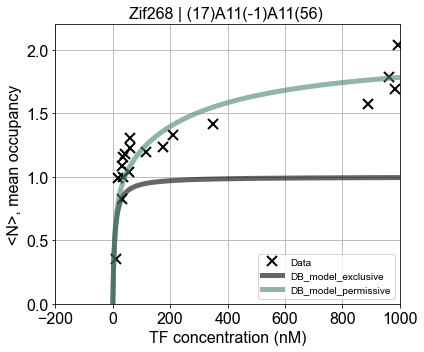

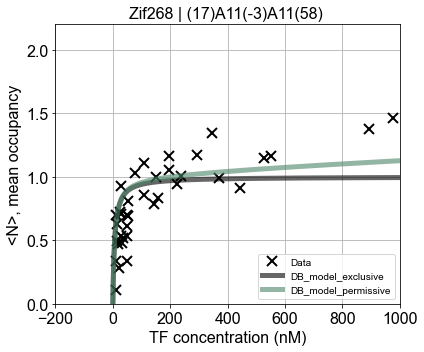

In [89]:
target_info = pd.read_csv(os.path.join('input_datasets','in-vitro','target_info.csv'), index_col=0)

C0 = 0.6e9
xs = np.logspace(-1,5,301)
N = 300

params_df = pd.DataFrame()

for tgt, tgtgrp in fdf.groupby('TgtName'):

    if tgt not in ['(17)A11(-1)A11(56)', '(17)A11(-3)A11(58)']:
        continue

    xd, yd = (tgtgrp['Free_nM'], tgtgrp['Meanocc']) 

    # Load data
    tgtgrp = tgtgrp.loc[(tgtgrp['Free_nM']>0)&(tgtgrp['Complex']>0)]
    xd, yd = (tgtgrp['Free_nM'], tgtgrp['Meanocc'])

    # Load dependent binding model
    sims_db = np.loadtxt(os.path.join(path,'Exclusive_statmech','{}_prediction_dependent-excl_smm.csv'.format(tgt)), delimiter=',')
    sims_perm = np.loadtxt(os.path.join(path,'Permissive_statmech','{}_posterior_sims_dp_model.csv'.format(tgt)), delimiter=' ')
            
    # Plot simulation and data
    median_excl = np.median(sims_db, axis=1)
    
    median_perm = np.median(sims_perm, axis=1)
    
    plt.figure(figsize=(6,5))
    plt.plot(xd, yd, 'k.', ms=10, marker='x', mew=2, label='Data')
    plt.plot(xs, median_excl, color='black', alpha=0.6, lw=5, label='DB_model_exclusive')
    plt.plot(xs, median_perm, color='#4B8467', alpha=0.6, lw=5, label='DB_model_permissive')
    plt.legend(loc='lower right')

    plt.xlim([-200, 1e3])
    plt.ylim([0, 2.20])
    plt.xlabel('TF concentration (nM)', fontsize=16)
    plt.ylabel('<N>, mean occupancy', fontsize=16)

    plt.grid(b=True, axis='both', zorder=1)

    plt.title("Zif268 | {} ".format(tgt), fontsize=16)
    plt.tight_layout()
    
    plt.savefig(os.path.join(path,'plots','{}_prediction_dependent-perm-excl.svg'.format(tgt)), dpi=300)
    plt.savefig(os.path.join(path,'plots','{}_prediction_dependent-perm-excl.jpg'.format(tgt)), dpi=300)
    
    plt.show()    

    plt.clf()
    plt.close('all')

##### Plotting independent model vs. perm vs. excl vs. single site

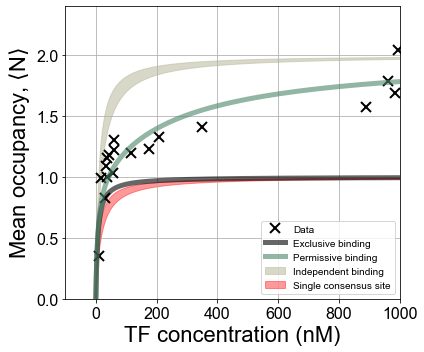

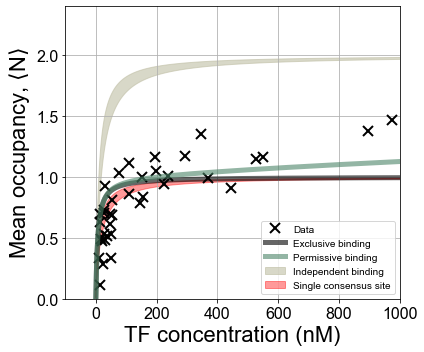

In [91]:
target_info = pd.read_csv(os.path.join('input_datasets','in-vitro','target_info.csv'), index_col=0)

C0 = 0.6e9
xs = np.logspace(-1,5,301)
xf = np.logspace(-1,5,10000) #note: logspace so -1 = 10^-1 = 1/10
N = 300

params_df = pd.DataFrame()

for tgt, tgtgrp in fdf.groupby('TgtName'):

    if tgt not in ['(17)A11(-1)A11(56)', '(17)A11(-3)A11(58)']:
        continue

    xd, yd = (tgtgrp['Free_nM'], tgtgrp['Meanocc']) #set x and y values

    # Load data
    tgtgrp = tgtgrp.loc[(tgtgrp['Free_nM']>0)&(tgtgrp['Complex']>0)]
    xd, yd = (tgtgrp['Free_nM'], tgtgrp['Meanocc'])

    # Load dependent binding model
    sims_db = np.loadtxt(os.path.join(path,'Exclusive_statmech','{}_prediction_dependent-excl_smm.csv'.format(tgt)), delimiter=',')
    median_excl = np.median(sims_db, axis=1)
    
    sims_perm = np.loadtxt(os.path.join(path,'Permissive_statmech','{}_posterior_sims_dp_model.csv'.format(tgt)), delimiter=' ')
    median_perm = np.median(sims_perm, axis=1)
    
    # Load A11 alone
    A11_ind = np.loadtxt(os.path.join(path, '1par_statmech_measured', '{}_posterior_sims_imsf_model.csv'.format(referenceSingleTargets['A11'])))
    A11_lower, A11_upper = np.percentile(A11_ind, [2.5,97.5], axis=1)
    
    sites = site_info[tgt]
    independent_sims = []
    
    for ss in sites: #for each ss in the target, append to sims the _posterior_sims.csv for that single site target (e.g. for M5XXXXX)
        if ss == 'None':
            print('nothing in that tgt')
            continue
        independent_sims.append(np.loadtxt(os.path.join(path, '1par_statmech_measured', '{}_posterior_sims_imsf_model.csv'.format(referenceSingleTargets[ss]))))
        
    independent_sims = sum(independent_sims)
    lower_ind, upper_ind = np.percentile(independent_sims, [2.5,97.5], axis=1) #independent target occupancy prediction


    plt.figure(figsize=(6,5))
    plt.plot(xd, yd, 'k.', ms=10, marker='x', mew=2, label='Data')
    plt.plot(xs, median_excl, color='black', alpha=0.6, lw=5, label='Exclusive binding')
    plt.plot(xs, median_perm, color='#4B8467', alpha=0.6, lw=5, label='Permissive binding')
    plt.fill_between(xf, lower_ind, upper_ind, color='#BFBEA4', alpha=0.6, label='Independent binding')
    plt.fill_between(xf, A11_lower, A11_upper, color='red', alpha=0.4, label='Single consensus site')
    
    plt.legend(loc='lower right')

    plt.xlim([-100, 1e3])
    plt.ylim([0, 2.40])
    plt.xlabel('TF concentration (nM)', fontsize=22)
    plt.ylabel( "Mean occupancy, "+r"$\langle$"+ "N"+ r"$\rangle$", fontsize=22)

    plt.grid(b=True, axis='both', zorder=1)

    plt.title("".format(tgt), fontsize=16)
    plt.tight_layout()
    
    plt.savefig(os.path.join(path,'plots','{}_predictions_ind-perm-excl-ss_.svg'.format(tgt)), dpi=300)
    plt.savefig(os.path.join(path,'plots','{}_predictions_ind-perm-excl-ss_.jpg'.format(tgt)), dpi=300)
    
    plt.show()    

    plt.clf()
    plt.close('all')

#### Plotting occupancy of 2-TF bound state

In [92]:
def twoSiteOverlap_perm_poccs(x, ehuh, de1, de2):
    #params1[0] is the Bmax (300,) pre-cal. factor, #params1[1] is the delE value (300,)... params1 = first site, params2 = second site
    # currently I'm doing it this way, but could multiply the params[0], to obtain dedicated max. occ. values on a per parameter basis
    # note that I'm plotting against other curves that are normalized by cal_factor

    #relMult = (conc/concO)*np.exp(-delE)

    C = x
    C0 = 0.6e9 #reference concentration parameter

    z0 = 1 # No sites bound
    z1 = np.outer( (C/C0), np.exp(-de1) ) # Rel. weighted mult.: multiply every X value with every parameter set (np.exp(-de1)): (301 by 300)
    z2 = np.outer( (C/C0), np.exp(-de2) )
    z3 = np.outer( (C/C0)**2, np.exp(-de1-de2-ehuh) )
    ztot = z0 + z1 + z2 + z3
    
    p0 = z0 / ztot
    p1 = z1 / ztot 
    p2 = z2 / ztot
    p3 = z3 / ztot
    occ = (z1 + z2 + 2*z3) / ztot
    occ = occ.flatten()
    
    res = {'p0':p0, 'p1':p1, 'p2':p2, 'p3':p3, 'N0':p0*0, 'N1':p1*1, 'N2':p2*1, 'N3':p3*2, 'occ':occ}
    return(res)

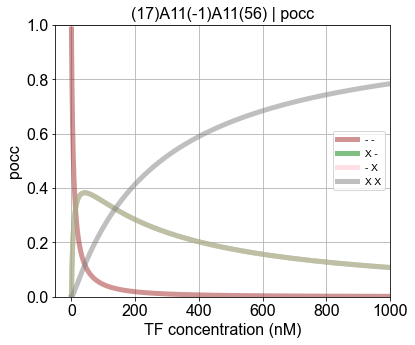

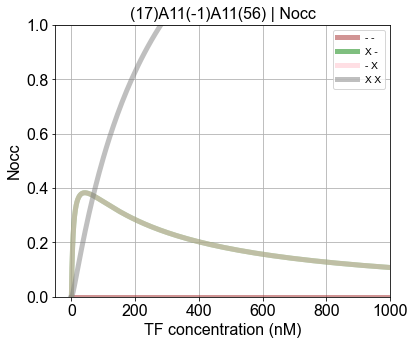

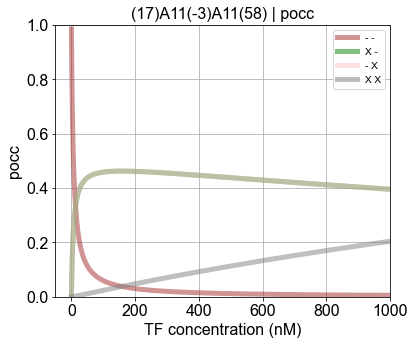

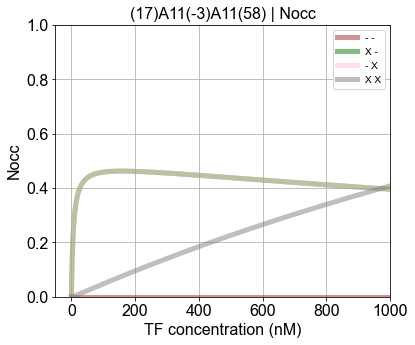

In [93]:
C0 = 0.6e9
xs = np.logspace(-1,5,301) #note: logspace so -1 = 10^-1 = 1/10
N=300

target_info = pd.read_csv(os.path.join('input_datasets','in-vitro','target_info.csv'), index_col=0)

ss_params = pd.read_csv(os.path.join(path, '1par_statmech_measured', 'fit_params_imsf_model.csv'), index_col=0)

params_df = pd.read_csv(os.path.join(path, 'Permissive_statmech', 'fit_params_smm_perm.csv'),index_col=0)

targets = ['(17)A11(-1)A11(56)','(17)A11(-3)A11(58)']

for tgt in targets:
    
    nrSites = target_info.loc[tgt,'NumSites']

    sites = site_info[tgt]
    params = []
    fixedParams = {}

    for ss in sites:
        if ss == 'None':
            continue

        params.append(ss_params.loc[referenceSingleTargets[ss], 'de1']) #pull the (median) de1 value for each site in tgt (note: to get proper confidence intervals, should probably fit 300 times -- once for each parameter set)

    if nrSites == 2:
        fixedParams['de1']=params[0]
        fixedParams['de2']=params[1]
        fixedParams['ehuh']=params_df.loc[tgt,'ehuh']
    else:
        print('method currently only designed for A11(-1)A11 target')

    results = twoSiteOverlap_perm_poccs(xs, fixedParams['ehuh'], fixedParams['de1'], fixedParams['de2'])

    for l in ['p', 'N']:
        plt.figure(figsize=(6,5))

        if len(sites) == 2:
            labels = ['- -', 'X -', '- X', 'X X']
            colors = ['brown', 'green', 'pink', 'grey']

        for i in range(4):
            configocc = results['{}{}'.format(l,i)]
            configocc = configocc.reshape(len(configocc))

            plt.plot(xs, configocc, color=colors[i], alpha=0.5, linewidth=5, label=labels[i])

        plt.grid(b=True, axis='both', zorder=1)

        plt.title('{} | {}occ'.format(tgt,l), fontsize=16)
        plt.xlabel('TF concentration (nM)', fontsize=16)
        plt.ylabel('{}occ'.format(l), fontsize=16)

        plt.xlim([-50, 1e3])
        plt.ylim([0, 1])
        plt.xscale('linear')

        plt.legend(loc='best')

        plt.savefig(os.path.join(path,'plots','{}_prediction_{}occs_perm.svg'.format(tgt,l)), dpi=300)
        plt.savefig(os.path.join(path,'plots','{}_prediction_{}occs_perm.jpg'.format(tgt,l)), dpi=300)

        plt.show()

        plt.clf()
        plt.close('all')
